#Set up Google Cloud Project and Google Earth Engine Project
1. Set up Google Cloud Project at this link https://console.cloud.google.com/apis/library
2. Search in the search bar for Google Earth Engine API and click enable
3. Register that project with Google Earth Engine at the link https://code.earthengine.google.com/
4. When running the code below, replace 'my-project' with your actual project ID, viewed in this same link: https://console.cloud.google.com/apis/library


In [151]:
pip install earthengine-api


In [152]:
import ee

# Use notebook auth mode so the URL appears
ee.Authenticate(auth_mode='notebook')

# Initialize with your project ID exactly as it appears in Google Cloud Console
ee.Initialize(project='flappymap')  # replace 'my-project' with your actual project ID


#Imports

In [153]:
# Import libraries
import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Getting data from Global Biodiversity Information Facility (GBIF) API

In [154]:
import requests
import pandas as pd
from typing import Union, List

def get_gbif_species_data(
    species_name: str,
    country_codes: Union[str, List[str]],
    limit: int = 10000
) -> pd.DataFrame:
    """
    Retrieves observational data for a specific species from one or more countries.

    Parameters:
    -----------
    species_name : str
        The scientific name of the species to query.
    country_codes : str or list of str
        A single country code (e.g. "US") or a list of them (e.g. ["US","CA","MX"]).
    limit : int
        Maximum records per API request (GBIF caps at 300,000 total; default 10,000).

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing all the combined occurrence records,
        with an extra column "country" indicating source country.
    """
    # ensure we have a list
    if isinstance(country_codes, str):
        country_codes = [country_codes]

    base_url = "https://api.gbif.org/v1/occurrence/search"
    all_records = []

    for code in country_codes:
        offset = 0
        while True:
            params = {
                "scientificName": species_name,
                "country": code,
                "hasCoordinate": "true",
                "basisOfRecord": "HUMAN_OBSERVATION",
                "limit": limit,
                "offset": offset
            }
            resp = requests.get(base_url, params=params)
            resp.raise_for_status()
            data = resp.json()
            results = data.get("results", [])

            if not results:
                break

            # tag each record with its country
            for rec in results:
                rec["country"] = code

            all_records.extend(results)

            # advance the cursor; stop if fewer than limit were returned
            if len(results) < limit:
                break
            offset += limit

    if not all_records:
        print("No data found for", species_name, "in", country_codes)
        return pd.DataFrame()

    # flatten into one DataFrame
    df = pd.json_normalize(all_records)
    return df


#In this case: Bar-bellied Pitta from Thailand (TH), Laos (LA), Cambodia (KH), and Vietnam (VN)

In [155]:
# Set pandas option to display all columns (so columns aren't truncated)
pd.set_option('display.max_columns', None)

# Retrieve Fairy Pitta data
df = get_gbif_species_data("Hydrornis elliotii", ['TH', 'LA', 'KH', 'VN']) #Change as needed: Coral-billed Ground Cuckoo from Thailand (TH)

df.head(5)  # Display the first row of the DataFrame

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,basisOfRecord,individualCount,occurrenceStatus,taxonKey,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,speciesKey,acceptedTaxonKey,scientificName,acceptedScientificName,kingdom,phylum,order,family,genus,species,genericName,specificEpithet,taxonRank,taxonomicStatus,iucnRedListCategory,decimalLatitude,decimalLongitude,continent,stateProvince,year,month,day,eventDate,startDayOfYear,endDayOfYear,issues,lastInterpreted,license,isSequenced,identifiers,media,facts,relations,isInCluster,recordedBy,dnaSequenceID,geodeticDatum,class,countryCode,recordedByIDs,identifiedByIDs,gbifRegion,country,publishedByGbifRegion,identifier,catalogNumber,vernacularName,institutionCode,taxonConceptID,locality,gbifID,collectionCode,occurrenceID,gadm.level0.gid,gadm.level0.name,gadm.level1.gid,gadm.level1.name,gadm.level2.gid,gadm.level2.name,gadm.level3.gid,gadm.level3.name,projectId,dateIdentified,coordinateUncertaintyInMeters,modified,references,datasetName,identifiedBy,rightsHolder,http://unknown.org/nick,informationWithheld,verbatimEventDate,dynamicProperties,verbatimLocality,taxonID,http://unknown.org/captive_cultivated,vitality,eventTime,identificationID,extensions.http://rs.gbif.org/terms/1.0/Multimedia,sex,lifeStage,preparations,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,associatedTaxa,samplingProtocol,habitat,identificationVerificationStatus,eventType,dataGeneralizations,occurrenceRemarks
0,4804118675,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,7182d304-b0a2-404b-baba-2086a325c221,e2e717bf-551a-4917-bdc9-4fa0f342c530,TH,DWC_ARCHIVE,2024-09-27T13:35:39.907+00:00,2025-02-05T05:47:22.390+00:00,20,HUMAN_OBSERVATION,1.0,PRESENT,6101089,1,44,212,729,9334,2489451,2489545,2489545,"Hydrornis elliotii (Oustalet, 1874)","Pitta elliotii Oustalet, 1874",Animalia,Chordata,Passeriformes,Pittidae,Pitta,Pitta elliotii,Hydrornis,elliotii,SPECIES,SYNONYM,LC,14.441578,105.344620,ASIA,Ubon Ratchathani,2023,4,19,2023-04-19,109,109,"[CONTINENT_DERIVED_FROM_COORDINATES, TAXON_MAT...",2025-02-05T05:47:22.390+00:00,http://creativecommons.org/licenses/by/4.0/leg...,False,[{'identifier': 'OBS1690247237'}],[],[],[],False,obsr2074140,[],WGS84,Aves,TH,[],[],ASIA,TH,ASIA,OBS1690247237,OBS1690247237,Bar-bellied Pitta,CLO,avibase-1F56AB5C,Phu Chong – Na Yoi NP (general area),4804118675,EBIRD,URN:catalog:CLO:EBIRD:OBS1690247237,THA,Thailand,THA.72_1,Ubon Ratchathani,THA.72.1_1,Buntharik,THA.72.1.2_1,Huai Kha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4772624748,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,7182d304-b0a2-404b-baba-2086a325c221,e2e717bf-551a-4917-bdc9-4fa0f342c530,TH,DWC_ARCHIVE,2024-09-27T13:35:39.907+00:00,2025-02-05T06:00:13.309+00:00,20,HUMAN_OBSERVATION,1.0,PRESENT,6101089,1,44,212,729,9334,2489451,2489545,2489545,"Hydrornis elliotii (Oustalet, 1874)","Pitta elliotii Oustalet, 1874",Animalia,Chordata,Passeriformes,Pittidae,Pitta,Pitta elliotii,Hydrornis,elliotii,SPECIES,SYNONYM,LC,14.436411,105.276360,ASIA,Ubon Ratchathani,2023,6,1,2023-06-01,152,152,"[CONTINENT_DERIVED_FROM_COORDINATES, TAXON_MAT...",2025-02-05T06:00:13.309+00:00,http://creativecommons.org/licenses/by/4.0/leg...,False,[{'identifier': 'OBS1855449399'}],[],[],[],False,obsr1244073,[],WGS84,Aves,TH,[],[],ASIA,TH,ASIA,OBS1855449399,OBS1855449399,Bar-bellied Pitta,CLO,avibase-1F56AB5C,Phu Chong – Na Yoi NP--Kaeng Ka Lao trail,4772624748,EBIRD,URN:catalog:CLO:EBIRD:OBS1855449399,THA,Thailand,THA.72_1,Ubon Ratchathani,THA.72.15_1,Na Chaluai,THA.72.15.2_1,Na Chaluai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4615385124,4fa7b334-c

In [156]:
df.shape

(643, 116)

#Convert the DataFrame to a GeoDataFrame

In [157]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, #takes in a DataFrame
    geometry=gpd.points_from_xy(df.decimalLongitude, #Adds a 'geometry' column
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]


gdf.head(1)  # Display the first row of the GeoDataFrame

,species,year,month,geometry
0,Pitta elliotii,2023,4,POINT (105.34462 14.44158)


# **CHANGE LATER IF NEEDED** Filter out year-month combinations with limited presence data
Plot presence frequency patterns in different months and years. Sparse presences in some years are unreliable and do not provide meaningful patterns that can be generalized. Thus, we are removing those.

In [158]:
import matplotlib.pyplot as plt

def plot_heatmap(gdf, figsize=(10,6), title="Monthly Species Count by Year"):
    """
    Draws a heatmap of counts by (month, year).
    - gdf: DataFrame with at least 'year' and 'month' columns.
    - figsize: tuple(width, height) for plt.figure()
    - title: string for plt.title()
    """
    # 1) aggregate into “month × year” table of counts
    stats = gdf.groupby(['month','year']).size().unstack(fill_value=0)

    # 2) ensure months 1–12 are always present
    all_months = list(range(1,13))
    stats = stats.reindex(all_months, fill_value=0)

    # 3) draw
    plt.figure(figsize=figsize)
    hm = plt.imshow(stats.values, cmap='viridis', origin='upper', aspect='auto')

    # 4) annotate each cell with its count
    for i, m in enumerate(stats.index):
        for j, y in enumerate(stats.columns):
            plt.text(j, i, str(stats.values[i, j]),
                     ha='center', va='center', color='black', fontsize=8)

    # 5) finish styling
    plt.colorbar(hm, label='Count')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Month')
    plt.xticks(range(len(stats.columns)), stats.columns, rotation=45)
    plt.yticks(range(len(stats.index)), stats.index)
    plt.tight_layout()
    plt.show()


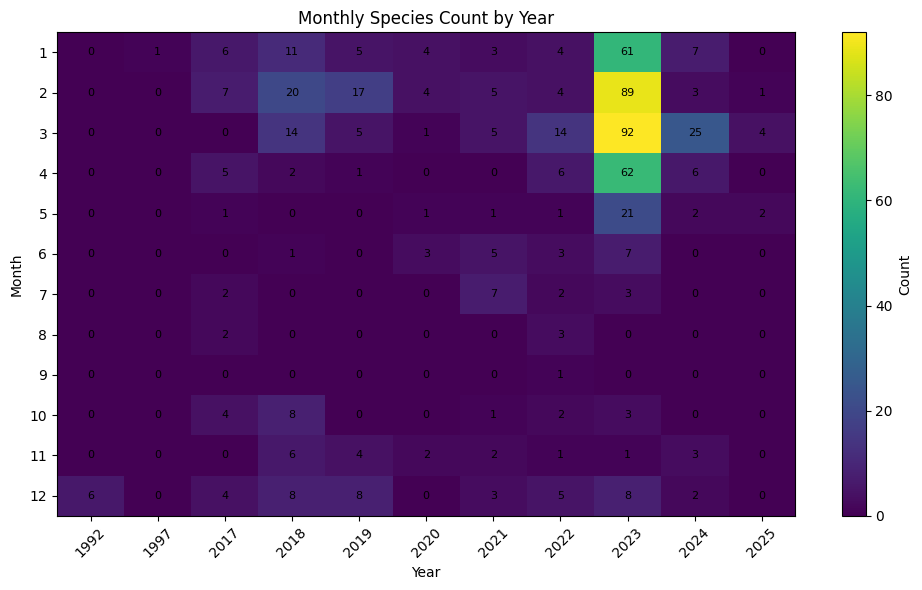

In [159]:
plot_heatmap(gdf)

Filter the original GeoDataFrame (named `gdf`) to remove sparse year-month presence (to a new GeoDataFrame named `filtered_gdf`)

In [160]:
import pandas as pd

def filter_sparse_periods(gdf, min_count=0): #change to any minimum count needed
    # Count presence per year-month
    counts = gdf.groupby(['year', 'month']).size().reset_index(name='count')

    # Filter year-month with counts >= min_count
    valid_periods = counts[counts['count'] >= min_count][['year', 'month']]

    # Keep only data from valid periods
    filtered_gdf = gdf.merge(valid_periods, on=['year', 'month'], how='inner')
    return filtered_gdf


In [161]:
filtered_gdf = filter_sparse_periods(gdf, min_count=0)

Compare pre-filter and post-filter data

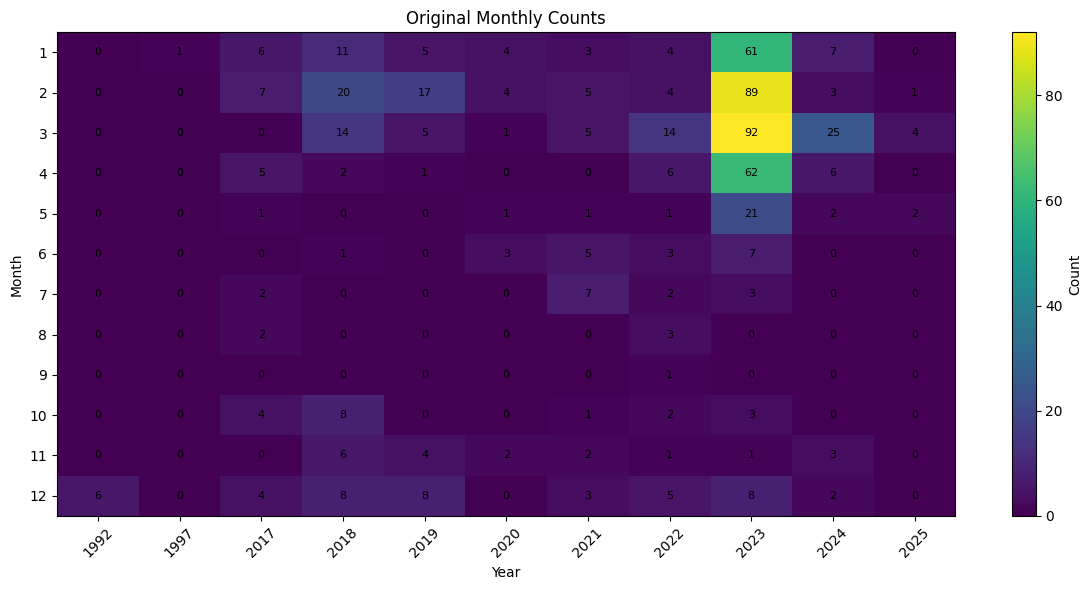

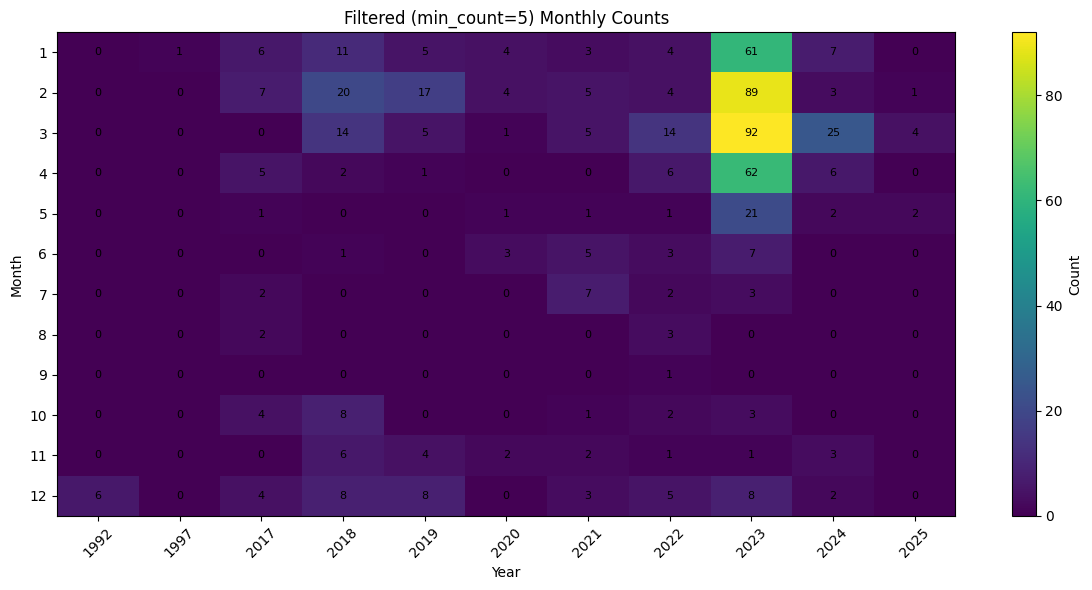

In [162]:
# 1) original heatmap (for comparison)
plot_heatmap(gdf, figsize=(12, 6), title="Original Monthly Counts")

# 2) filtered heatmap
plot_heatmap(filtered_gdf, figsize=(12, 6), title="Filtered (min_count=5) Monthly Counts")


In [163]:
import pandas as pd

# 1) Total removed:
total_removed = len(gdf) - len(filtered_gdf)
print(f"Total presence points removed: {total_removed}")

# 2) Breakdown by year:
#    a) Count how many rows came from each year in the original
orig_counts_by_year = gdf['year'].value_counts().sort_index()

#    b) Count how many remain in each year after filtering
filt_counts_by_year = filtered_gdf['year'].value_counts().sort_index()

#    c) Build a small DataFrame so we can see “original vs. filtered vs. removed”
year_comparison = pd.DataFrame({
    'original' : orig_counts_by_year,
    'filtered' : filt_counts_by_year
}).fillna(0).astype(int)

year_comparison['removed'] = year_comparison['original'] - year_comparison['filtered']

#    d) Print only those years where at least one row was removed
removed_years = year_comparison[year_comparison['removed'] > 0]

print("\nCounts by year (only years with removals shown):")
print(removed_years)


Total presence points removed: 0

Counts by year (only years with removals shown):
Empty DataFrame
Columns: [original, filtered, removed]
Index: []


In [164]:
# Convert GeoDataFrame to Earth Engine object
data_raw = geemap.geopandas_to_ee(filtered_gdf)

#Grid size set at 1000 m resolution

In [165]:
# Spatial resolution setting (meters)
grid_size = 1000

#Sampling presence from a grid
When multiple occurrence points are present within the same 1km resolution raster pixel, there is a high likelihood that they share the same environmental conditions at the same geographic location. Using such data directly in the analysis can introduce bias into the results.

In other words, we need to limit the potential impact of geographic sampling bias. To achieve this, we will retain only one location within each 1km pixel and remove all others, allowing the model to more objectively reflect the environmental conditions.

In [166]:
def remove_duplicates(data, grid_size):
    # Select one presence record per pixel at the chosen spatial resolution
    random_raster = ee.Image.random().reproject("EPSG:4326", None, grid_size)
    rand_point_vals = random_raster.sampleRegions(
        collection=ee.FeatureCollection(data), geometries=True
    )
    return rand_point_vals.distinct("random")


data = remove_duplicates(data_raw, grid_size)

# Before selection and after selection
print("Original data size:", data_raw.size().getInfo())
print("Final data size:", data.size().getInfo())

Original data size: 643
Final data size: 93


In [167]:
# Visualization of geographic sampling bias before (blue) and after (red) preprocessing
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

# Add the random raster layer
random_raster = ee.Image.random().reproject("EPSG:4326", None, grid_size)
Map.addLayer(
    random_raster,
    {"min": 0, "max": 1, "palette": ["black", "white"], "opacity": 0.5},
    "Random Raster",
)

# Add the original data layer in blue
Map.addLayer(data_raw, {"color": "blue"}, "Original data")

# Add the final data layer in red
Map.addLayer(data, {"color": "red"}, "Final data")

# Set the center of the map to the coordinates -- change as needed
Map.setCenter(101.53, 14.31, 5)
Map

Map(center=[14.31, 101.53], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

#Define area of interest and set a buffer

In [168]:
# Define the AOI
aoi = data.geometry().bounds().buffer(distance=200000, maxError=1000)

# Add the AOI to the map
outline = ee.Image().byte().paint(
    featureCollection=aoi, color=1, width=3)

Map.remove_layer("Random Raster")
Map.addLayer(outline, {'palette': 'FF0000'}, "AOI")
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

#Extracting Climate Variables (Bioclim) from GEE


In [169]:
# WorldClim V1 Bioclim
bio = ee.Image("WORLDCLIM/V1/BIO")

#Extracting Topography Data (SRTM)

In [170]:
# NASA SRTM Digital Elevation 30m
terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

#Extracting Forest Cover Data
The Vegetation Continuous Fields (VCF) dataset from Landsat estimates the proportion of vertically projected vegetation cover when the vegetation height is greater than 5 meters. This dataset is provided for four time periods centered around the years 2000, 2005, 2010, and 2015, with a resolution of 30 meters. Here, the median values from these four time periods are used.

In [171]:
# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
tcc = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
median_tcc = (
    tcc.filterDate("2000-01-01", "2015-12-31")
    .select(["tree_canopy_cover"], ["TCC"])
    .median()
)

bio (Bioclimatic variables), terrain (topography), and median_tcc (tree canopy cover) are combined into a single multiband image. The elevation band is selected from terrain, and a watermask is created for locations where elevation is greater than 0. This masks regions below sea level (e.g. the ocean) and prepares the researcher to analyze various environmental factors for the AOI comprehensively.

In [172]:
# Combine bands into a multi-band image (predictors are environmental variables)
predictors = bio.addBands(terrain).addBands(median_tcc)

# Create a water mask
watermask = terrain.select('elevation').gt(0)

# Mask out ocean pixels and clip to the area of interest
predictors = predictors.updateMask(watermask).clip(aoi)

When highly correlated predictor variables are included together in a model, multicollinearity issues can arise. Multicollinearity is a phenomenon that occurs when there are strong linear relationships among independent variables in a model, leading to instability in the estimation of the model's coefficients (weights). This instability can reduce the model's reliability and make predictions or interpretations for new data challenging. Therefore, we will consider multicollinearity and proceed with the process of selecting predictor variables.

First, we will generate 5,000 random points and then extract the predictor variable values of the single multiband image at those points.

In [173]:
# Generate 5,000 random points
data_cor = predictors.sample(scale=grid_size, numPixels=5000, geometries=True)

# Extract predictor variable (environmental variable) values
pvals = predictors.sampleRegions(collection=data_cor, scale=grid_size)

In [174]:
# Converting predictor values from Earth Engine to a DataFrame
pvals_df = geemap.ee_to_df(pvals)
pvals_df.head(5)

,TCC,aspect,bio01,bio02,bio03,bio04,bio05,bio06,bio07,bio08,bio09,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,elevation,hillshade,slope
0,23.0,90,271,95,55,1643,350,180,170,272,252,291,247,1713,374,2,91,971,18,255,56,76,180,0
1,14.5,180,268,65,65,881,315,215,100,271,260,278,255,2176,338,7,70,1002,53,614,81,2,180,0
2,35.0,125,189,116,53,3212,278,63,215,218,153,220,141,1681,325,18,77,889,71,709,81,1175,154,10
3,18.5,0,273,70,64,831,324,216,108,273,266,283,261,1534,260,6,68,674,43,415,55,3,180,0
4,72.5,184,215,91,67,948,277,143,134,218,201,225,201,2026,317,24,63,923,112,523,112,830,181,4


In [175]:
# Displaying the columns
columns = pvals_df.columns
print(columns)

Index(['TCC', 'aspect', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06',
       'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14',
       'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'elevation', 'hillshade',
       'slope'],
      dtype='object')


In [176]:
from geemap import ee_to_df

# 1) Make sure Earth Engine is initialized
ee.Initialize()

# Define the FeatureCollection (presence data)
# Replace this with your actual FeatureCollection (e.g., 'data' or 'data_raw')
presence_fc = data  # Example: data or data_raw

# Convert the FeatureCollection to a Pandas DataFrame (this should already include the properties of each feature)
pres_df = ee_to_df(presence_fc)

# Check the first few rows of the DataFrame to ensure it's loaded correctly
print("First few rows of the DataFrame:")
print(pres_df.head())

# Extract the geometry and longitude/latitude from the FeatureCollection
def extract_coordinates(feature):
    geometry = feature['geometry']
    coords = geometry['coordinates'] if geometry is not None else [None, None]
    return coords[0], coords[1]  # longitude, latitude

# Extract the coordinates for all features and add them as new columns
coordinates = [extract_coordinates(f) for f in presence_fc.getInfo()['features']]
longitudes, latitudes = zip(*coordinates)

# Add the longitude and latitude columns to the DataFrame
pres_df['longitude'] = longitudes
pres_df['latitude'] = latitudes

# Ensure that the 'species' column is present
if 'species' not in pres_df.columns:
    pres_df['species'] = pres_df['species'].fillna('unknown')

# Now, select and write out the relevant columns to a CSV
pres_df.loc[:, ['species', 'longitude', 'latitude']].to_csv('presence_records.csv', index=False)

print(f"Wrote presence_records.csv with {len(pres_df)} rows.")


First few rows of the DataFrame:
   month    random         species  year
0      4  0.583171  Pitta elliotii  2023
1      6  0.952996  Pitta elliotii  2023
2      4  0.879860  Pitta elliotii  2022
3      4  0.097736  Pitta elliotii  2022
4      4  0.325725  Pitta elliotii  2022
Wrote presence_records.csv with 93 rows.


In [177]:
# import os
# import ee
# from osgeo import gdal
# import time

# # Initialize Earth Engine
# ee.Initialize()

# # Ensure you're using the same AOI from earlier code (from filtered_gdf or your AOI)
# aoi_bounds = filtered_gdf.geometry.total_bounds  # Get the bounding box (minx, miny, maxx, maxy)
# aoi = ee.Geometry.Polygon([[[aoi_bounds[0], aoi_bounds[1]], [aoi_bounds[2], aoi_bounds[1]], [aoi_bounds[2], aoi_bounds[3]], [aoi_bounds[0], aoi_bounds[3]]]])

# # Define the grid size (in meters)
# grid_size = 1000  # 1km resolution

# # WorldClim V1 Bioclim variables
# bio = ee.Image("WORLDCLIM/V1/BIO")

# # NASA SRTM Digital Elevation 30m
# terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

# # Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
# tcc = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
# median_tcc = tcc.filterDate("2000-01-01", "2015-12-31").select(["tree_canopy_cover"], ["TCC"]).median()

# # Combine bands into a multi-band image (predictors are environmental variables)
# predictors = bio.addBands(terrain).addBands(median_tcc)

# # Create a water mask to exclude ocean pixels
# watermask = terrain.select('elevation').gt(0)

# # Mask out ocean pixels and clip to the area of interest (AOI)
# predictors = predictors.updateMask(watermask).clip(aoi)

# # Create the output directory for the layers (on Google Drive)
# os.makedirs('/content/drive/My Drive/layers', exist_ok=True)  # Save to Google Drive

# # Loop through each image band in the combined predictors
# band_names = predictors.bandNames().getInfo()  # Get band names of the combined image

# # Export each band to Google Drive as GeoTIFF (MaxEnt compatible format can be converted later)
# for band in band_names:
#     print(f"Starting export of {band}...")

#     # Export the band as GeoTIFF format to Google Drive
#     task = ee.batch.Export.image.toDrive(
#         image=predictors.select(band),          # Select the band
#         description=f'export_{band}',           # Description of the export task
#         folder='layers',                       # Folder in Google Drive to store the layers
#         fileNamePrefix=f'{band}',              # Prefix for the exported file
#         region=aoi.bounds().getInfo()['coordinates'],  # Clip the export to the AOI
#         scale=grid_size,                       # Define the scale (resolution)
#         crs='EPSG:4326',                       # Coordinate reference system (WGS84)
#         fileFormat='GeoTIFF'                   # Export format (GeoTIFF)
#     )

#     # Start the export task
#     task.start()

# print("All export tasks started.  Use the Tasks tab in the GEE Code Editor or Drive UI to monitor them.")

# # --- Wait for the export tasks to complete ---
# # You can use `time.sleep()` to add a delay before the conversion begins,
# # ensuring that the export tasks are completed and the files are available.

# # Set the wait time (in seconds) based on expected task duration
# print("Waiting for export tasks to finish...")
# time.sleep(30)

# # --- Conversion Code (to be run once exports are complete) ---

# def convert_tif_to_asc(tif_file, asc_file):
#     """
#     Convert a GeoTIFF file to ASCII (.asc) format using GDAL.
#     """
#     # Open the GeoTIFF file
#     dataset = gdal.Open(tif_file)

#     # Check if the dataset was opened successfully
#     if dataset is None:
#         print(f"Failed to open {tif_file}")
#         return

#     # Get the GeoTIFF driver
#     driver = gdal.GetDriverByName('AAIGrid')

#     # Convert to ASCII grid format
#     if driver is None:
#         print("AAIGrid driver not available.")
#         return

#     # Create an ASCII grid file
#     driver.CreateCopy(asc_file, dataset)
#     print(f"Converted {tif_file} to {asc_file}")

# # Now that Google Drive is mounted, the path to the 'layers' folder is:
# download_folder = '/content/drive/My Drive/layers'  # This is the Google Drive folder

# # You should call this after the exports are finished.
# for band in band_names:
#     tif_file = os.path.join(download_folder, f"{band}.tif")  # Example: layers/bio01.tif
#     asc_file = os.path.join(download_folder, f"{band}.asc")  # Example: layers/bio01.asc

#     # Call the conversion function
#     convert_tif_to_asc(tif_file, asc_file)

# print("Conversion to ASC format completed.")


#Understanding general correlations with Spearman Correlation Coefficient (not multicollinearity yet)

In [178]:
import matplotlib.pyplot as plt

def plot_correlation_heatmap(dataframe, h_size=10, show_labels=True):
    # Calculate Spearman correlation coefficients
    correlation_matrix = dataframe.corr(method="spearman")

    # Create a heatmap
    plt.figure(figsize=(h_size, h_size - 2))
    im = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # Display values on the heatmap using black text
    if show_labels:
        for i in range(correlation_matrix.shape[0]):
            for j in range(correlation_matrix.shape[1]):
                value = correlation_matrix.iloc[i, j]
                plt.text(j, i, f"{value:.2f}",
                         ha='center', va='center', color='black', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables Correlation Matrix")
    plt.colorbar(im, label="Spearman Correlation")
    plt.tight_layout()
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()


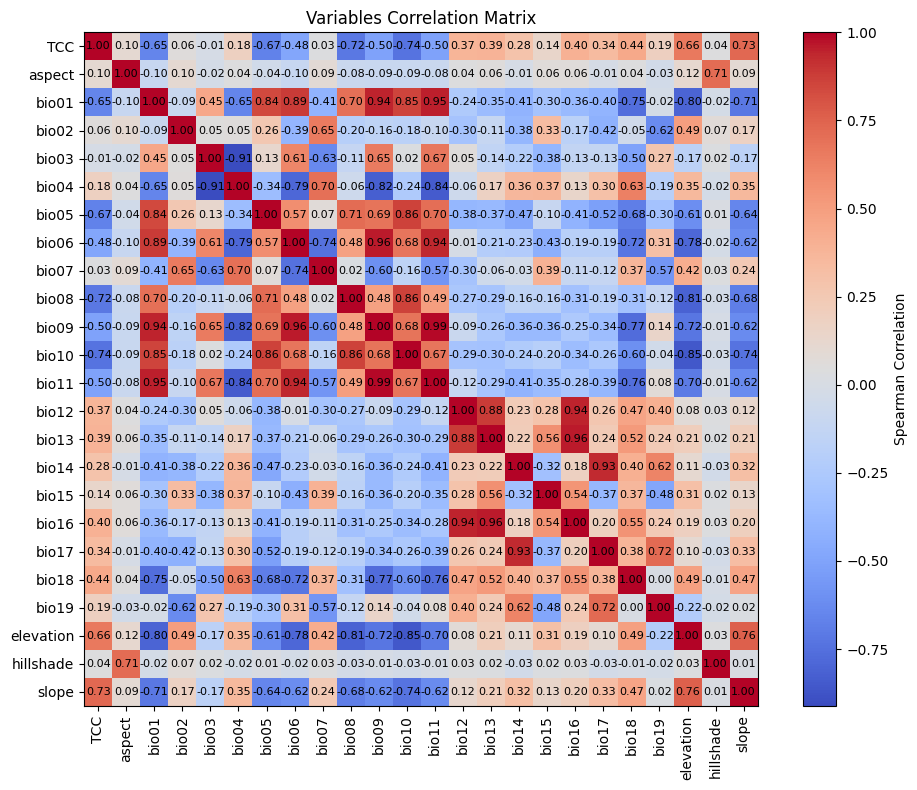

In [179]:
# Plot the correlation heatmap of variables
plot_correlation_heatmap(pvals_df)

#Using Variance Inflation Factor (VIF) to evaluate multicollinearity
Typically, when VIF values exceed 5 or 10, it suggests that the variable has a strong correlation with other variables, potentially compromising the stability and interpretability of the model. Here, the threshold for maximum possible VIF allowed is 10.

In [180]:
# Filter variables based on Variance Inflation Factor (VIF)
def filter_variables_by_vif(dataframe, threshold=10):

    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [
            variance_inflation_factor(vif_data.values, i)
            for i in range(vif_data.shape[1])
        ]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print("Bands:", bands)

    return filtered_data, bands

In [181]:
filtered_pvals_df, bands = filter_variables_by_vif(pvals_df)

Removing 'bio05' with VIF inf
Removing 'bio11' with VIF 121318.59
Removing 'bio10' with VIF 86274.05
Removing 'bio01' with VIF 18120.09
Removing 'bio08' with VIF 5610.76
Removing 'bio07' with VIF 3721.40
Removing 'bio09' with VIF 2581.14
Removing 'bio16' with VIF 1275.81
Removing 'bio03' with VIF 831.51
Removing 'hillshade' with VIF 352.30
Removing 'bio15' with VIF 350.11
Removing 'bio12' with VIF 148.91
Removing 'bio17' with VIF 52.56
Removing 'bio02' with VIF 45.59
Removing 'bio13' with VIF 18.02
Removing 'bio04' with VIF 11.61
Bands: ['TCC', 'aspect', 'bio06', 'bio14', 'bio18', 'bio19', 'elevation', 'slope']


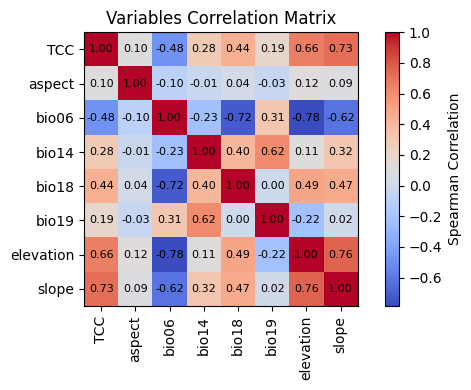

In [182]:
# Variable Selection Based on VIF
predictors = predictors.select(bands)

# Plot the correlation heatmap of variables
plot_correlation_heatmap(filtered_pvals_df, h_size=6, show_labels=True)

#Visualize remaining predictors (environmental variables) on a heatmap

In [183]:
# Elevation layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['elevation'], 'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [184]:
# Slope layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [185]:
# Aspect layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [186]:
# Calculate the minimum and maximum values for bio06
min_max_val = (
    predictors.select("bio06")
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio06 (Mean Temperature of Warmest Quarter (°C)) layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["bio06"],
    "min": math.floor(min_max_val["bio06_min"]),
    "max": math.ceil(min_max_val["bio06_max"]),
    "palette": cm.palettes.YlGnBu,
}
Map.addLayer(predictors, vis_params, "bio06")
Map.add_colorbar(
    vis_params,
    label="Mean Temperature of Warmest Quarter (°C)",
    orientation="vertical",
    layer_name="bio06",
)
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [187]:
# Calculate the minimum and maximum values for bio14
min_max_val = (
    predictors.select("bio14")
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio14 (Precipitation of driest month) layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["bio14"],
    "min": math.floor(min_max_val["bio14_min"]),
    "max": math.ceil(min_max_val["bio14_max"]),
    "palette": cm.palettes.Blues,
}
Map.addLayer(predictors, vis_params, "bio14")
Map.add_colorbar(
    vis_params,
    label="Precipitation of driest month (mm)",
    orientation="vertical",
    layer_name="bio14",
)
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [188]:
# Calculate the minimum and maximum values for bio18
min_max_val = (
    predictors.select("bio18")
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio14 (Precipitation of Warmest Quarter (mm)) layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["bio18"],
    "min": math.floor(min_max_val["bio18_min"]),
    "max": math.ceil(min_max_val["bio18_max"]),
    "palette": cm.palettes.Blues,
}
Map.addLayer(predictors, vis_params, "bio18")
Map.add_colorbar(
    vis_params,
    label="Precipitation of Warmest Quarter (mm)",
    orientation="vertical",
    layer_name="bio18",
)
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [189]:
# Calculate the minimum and maximum values for bio19
min_max_val = (
    predictors.select("bio19")
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# Extract the actual min and max values for bio19
bio19_min = min_max_val["bio19_min"]
bio19_max = min_max_val["bio19_max"]

# Check the values
print(f"bio19 Min: {bio19_min}, bio19 Max: {bio19_max}")

# Now set the correct color range based on the actual data values
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["bio19"],
    "min": bio19_min,  # Use the actual minimum value
    "max": bio19_max,  # Use the actual maximum value
    "palette": cm.palettes.Blues,
}

Map.addLayer(predictors, vis_params, "bio19")
Map.add_colorbar(
    vis_params,
    label="Precipitation of Coldest Quarter (mm)",
    orientation="vertical",
    layer_name="bio19",
)

Map.centerObject(aoi, 6)
Map


bio19 Min: 6, bio19 Max: 2021


Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [190]:
# TCC layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["TCC"],
    "min": 0,
    "max": 100,
    "palette": ["ffffff", "afce56", "5f9c00", "0e6a00", "003800"],
}
Map.addLayer(predictors, vis_params, "TCC")
Map.add_colorbar(
    vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC"
)
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

# **CHANGE LATER IF NEEDED** Sampling Pseudo-absence from a different environmental cluster from presence records
The generation of pseudo-absence data will be done through the "environmental profiling approach", and the specific steps are as follows:

1. Environmental Classification Using k-means Clustering: The k-means clustering algorithm, based on Euclidean distance, will be used to divide the pixels within the study area into two clusters. One cluster will represent areas with similar environmental characteristics to randomly selected 100 presence locations, while the other cluster will represent areas with different characteristics.

2. Generation of Pseudo-Absence Data within Dissimilar Clusters: Within the second cluster identified in the first step (which has different environmental characteristics from the presence data), randomly generated pseudo-absence points will be created. These pseudo-absence points will represent locations where the species is not expected to exist.

In [191]:
# Randomly select 100 locations for occurrence
pvals = predictors.sampleRegions(
    collection=data.randomColumn().sort('random').limit(100),
    properties=[],
    scale=grid_size
)

# Perform k-means clustering
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(pvals)

cl_result = predictors.cluster(clusterer)

# Get cluster ID for locations similar to occurrence
cl_id = cl_result.sampleRegions(
    collection=data.randomColumn().sort('random').limit(200),
    properties=[],
    scale=grid_size
)

# Define non-occurrence areas in dissimilar clusters
cl_id = ee.FeatureCollection(cl_id).reduceColumns(ee.Reducer.mode(), ['cluster'])
cl_id = ee.Number(cl_id.get('mode')).subtract(1).abs()
cl_mask = cl_result.select(['cluster']).eq(cl_id)

In [192]:
# Presence location mask
presence_mask = data.reduceToImage(properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, grid_size).mask().neq(1).selfMask()

# Masking presence locations in non-occurrence areas and clipping to AOI
area_for_pa = presence_mask.updateMask(cl_mask).clip(aoi)

# Display map
Map = geemap.Map(layout={'height': '400px', 'width': '800px'})
Map.addLayer(area_for_pa, {'palette': 'black'}, 'AreaForPA')
Map.addLayer(data, {'color': 'red'}, 'Presence Points')  # <-- Added line
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

# Split train-test datasets and be aware of Spatial Correlation
Spatial autocorrelation is an essential element in SDM, associated with Tobler's law. It embodies the concept that "everything is related to everything else, but near things are more related than distant things". Spatial autocorrelation represents the significant relationship between the location of species and environmental variables. However, if spatial autocorrelation exists between the training and test data, the independence between the two data sets can be compromised. This significantly impacts the evaluation of the model's generalization ability.

1. Creation of spatial blocks: Divide the entire dataset into spatial blocks of equal size (e.g., 50x50 km).
2. Assignment of training and testing sets: Each spatial block is randomly assigned to either the training set (70%) or the test set (30%). This prevents the model from overfitting to data from specific areas and aims to achieve more generalized results.
3. Iterative cross-validation: The entire process is repeated n times (e.g., 10 times). In each iteration, the blocks are randomly divided into training and test sets again, which is intended to improve the model's stability and reliability.
4. Generation of pseudo-absence data: In each iteration, pseudo-absence data are randomly generated to evaluate the model's performance.



In [193]:
# 1) TAG EACH PRESENCE WITH PresAbs=1
presence_points = data.map(lambda f: f.set('PresAbs', 1))

# 2) SAMPLE PSEUDO-ABSENCE CANDIDATES FROM area_for_pa
raw_absences = area_for_pa.sample(
    region=aoi,
    scale=grid_size,
    numPixels=presence_points.size().multiply(5),
    seed=42,
    geometries=True
)

# 3) MATCH THE NUMBER OF ABSENCES TO THE NUMBER OF PRESENCES
actual_absences  = raw_absences.size()
desired_absences = presence_points.size()
usable_count     = actual_absences.min(desired_absences)

balanced_absences = raw_absences \
    .limit(usable_count) \
    .map(lambda f: f.set('PresAbs', 0))


In [194]:
Scale = 50000
grid = watermask.reduceRegions(
    collection=aoi.coveringGrid(scale=Scale, proj='EPSG:4326'),
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.addLayer(grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(aoi, 6)
Map

Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

# **CHANGE LATER TO DO MANY PARTITION TYPES (SPATIAL BLOCK, CHECKERBOARD, RANDOM)** Hierarchical Checkerboard Fold


In [195]:
import ee
import geemap
import math

ee.Initialize()  # (Or ee.Authenticate(); ee.Initialize() if you haven’t already.)

# ──────────────────────────────────────────────────────────────────────────────
# ASSUMPTIONS: Up to this point in your notebook you have defined:
#    • aoi               = ee.Geometry         (your area of interest in EPSG:4326)
#    • data              = ee.FeatureCollection (your deduplicated presence points)
#    • balanced_absences = ee.FeatureCollection (your pseudo-absence points)
#
# This block will:
#    1) Pull the AOI bounding box on the client (via .getInfo()).
#    2) Build a uniform dx_degrees × dy_degrees grid over that bbox, tagging each
#       tile with (col, row, fold) where fold = (col mod 2) + 2*(row mod 2).
#    3) Wrap all those tiles into an ee.FeatureCollection, then keep only those
#       tiles that intersect `aoi` (with .filterBounds(aoi)).
#    4) Assign the fold ID to each presence/absence point by finding its containing tile.
#    5) Visualize and print a summary of fold counts.
# ──────────────────────────────────────────────────────────────────────────────

# 1) CHOOSE THE GRID SIZE IN DEGREES
#    For example, 0.5° × 0.5°. You can change these to any other degree spacing.
dx_degrees = 0.5
dy_degrees = 0.5

# 2) GET THE AOI BOUNDING BOX ON THE CLIENT
#    We do this by calling .getInfo() on the bounds() geometry.
#    The returned dictionary looks like:
#       {
#         "type": "Polygon",
#         "coordinates": [
#           [
#             [lon_min, lat_min],
#             [lon_max, lat_min],
#             [lon_max, lat_max],
#             [lon_min, lat_max],
#             [lon_min, lat_min]
#           ]
#         ]
#       }
bbox_info = aoi.bounds().getInfo()

# Extract the outer ring of coordinates (a list of five [lon, lat] pairs)
outer_ring = bbox_info['coordinates'][0]
# Parse Python floats:
lon_min = float(outer_ring[0][0])
lat_min = float(outer_ring[0][1])
lon_max = float(outer_ring[1][0])
lat_max = float(outer_ring[2][1])

# 3) COMPUTE HOW MANY COLUMNS (n_cols) AND ROWS (n_rows) FIT
n_cols = int(math.ceil((lon_max - lon_min) / dx_degrees))
n_rows = int(math.ceil((lat_max - lat_min) / dy_degrees))

# 4) BUILD A LIST OF ee.Feature TILES (IN PYTHON)
features = []
for col in range(n_cols):
    for row in range(n_rows):
        # Compute the corners of this tile in lon/lat
        x0 = lon_min + col * dx_degrees
        y0 = lat_min + row * dy_degrees
        x1 = x0 + dx_degrees
        y1 = y0 + dy_degrees
        # Create the rectangular polygon in EPSG:4326
        poly = ee.Geometry.Rectangle([x0, y0, x1, y1])
        # Compute the fold ID: (col mod 2) + 2*(row mod 2) ∈ {0,1,2,3}
        fold_id = (col % 2) + 2 * (row % 2)
        # Store col, row, fold in the feature’s properties
        feat = ee.Feature(poly, {
            'col': col,
            'row': row,
            'fold': fold_id
        })
        features.append(feat)

# 5) WRAP THEM INTO A SINGLE ee.FeatureCollection
grid_full = ee.FeatureCollection(features)

# 6) KEEP ONLY THOSE TILES THAT INTERSECT YOUR AOI
grid_final = grid_full.filterBounds(aoi)

# At this point, `grid_final` is a FeatureCollection of polygons, each clipped to the AOI if necessary,
# each with properties 'col', 'row', and 'fold' ∈ {0,1,2,3}, arranged in a perfect 2×2 checkerboard.


# 7) OPTIONAL: VISUALIZE THE FOUR-FOLD GRID BY ITSELF TO VERIFY IT’S UNIFORM
fold_palette = {
    0: 'FF0000',   # red
    1: '0000FF',   # blue
    2: '00FF00',   # green
    3: 'FFA500'    # orange
}
alpha_hex = '4D'  # approximate 30% opacity

grid_map = geemap.Map(
    center=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2],
    zoom=6
)
grid_map.addLayer(aoi, {'color': '000000'}, 'AOI Outline (black)')
for fv, hexcol in fold_palette.items():
    fc = grid_final.filter(ee.Filter.eq('fold', fv))
    styled = fc.style(color=hexcol, width=1, fillColor=hexcol + alpha_hex)
    grid_map.addLayer(styled, {}, f'Grid Fold {fv}')
grid_map.centerObject(aoi, 7)
grid_map  # ← should show a perfect red/blue/green/orange checkerboard over your AOI


# 8) ASSIGN “fold” TO PRESENCE / ABSENCE POINTS
def assign_fold_to_point(pt):
    """
    Find the single grid tile in `grid_final` that contains this point,
    then copy its 'fold' property onto the point.
    """
    containing_tile = grid_final.filterBounds(pt.geometry()).first()
    return pt.set('fold', ee.Feature(containing_tile).get('fold'))

# 8.1) PRESENCE POINTS: add property 'PresAbs'=1, then assign fold
presence_with_folds = data.map(lambda f: f.set('PresAbs', 1)).map(assign_fold_to_point)

# 8.2) ABSENCE POINTS: assign fold (we assume 'balanced_absences' already has 'PresAbs'=0)
absences_with_folds = balanced_absences.map(assign_fold_to_point)

# 8.3) MERGE THEM AND DROP ANY POINT WITH NO FOLD (just in case)
all_points = presence_with_folds.merge(absences_with_folds) \
                .filter(ee.Filter.neq('fold', None))

# 9) VISUALIZE THE FINAL GRID + POINTS BY FOLD
final_map = geemap.Map(layout={'height': '400px', 'width': '800px'})
final_map.addLayer(aoi, {'color': '000000'}, 'AOI Outline (black)')

for fv, hexcol in fold_palette.items():
    # 9.1) The (possibly clipped) polygons of that fold
    fc_tiles = grid_final.filter(ee.Filter.eq('fold', fv))
    styled_tiles = fc_tiles.style(color=hexcol, width=1, fillColor=hexcol + alpha_hex)
    final_map.addLayer(styled_tiles, {}, f'Grid Fold {fv}')
    # 9.2) The points (presence or absence) in that fold
    fc_pts = all_points.filter(ee.Filter.eq('fold', fv))
    final_map.addLayer(fc_pts, {'color': hexcol}, f'Points Fold {fv}')

final_map.centerObject(aoi, 6)


# 10) PRINT A SUMMARY OF PRESENCE/ABSENCE COUNTS PER FOLD
print("\n=== Fold Summary ===")
for fv in [0, 1, 2, 3]:
    fc = all_points.filter(ee.Filter.eq('fold', fv))
    total = fc.size().getInfo()
    pres = fc.filter(ee.Filter.eq('PresAbs', 1)).size().getInfo()
    absn = fc.filter(ee.Filter.eq('PresAbs', 0)).size().getInfo()
    role = "Held‐out TEST" if fv == 3 else "CV"
    print(f"Fold {fv} [{role}]: TOTAL = {total:,}   PRES = {pres:,}   ABS = {absn:,}")

# ──────────────────────────────────────────────────────────────────────────────
final_map  # ← now you should see all presence/absence points colored exactly in step with the 4‐fold grid



=== Fold Summary ===
Fold 0 [CV]: TOTAL = 55   PRES = 41   ABS = 14
Fold 1 [CV]: TOTAL = 42   PRES = 23   ABS = 19
Fold 2 [CV]: TOTAL = 42   PRES = 15   ABS = 27
Fold 3 [Held‐out TEST]: TOTAL = 47   PRES = 14   ABS = 33


Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

NameError: name 'abs_df' is not defined

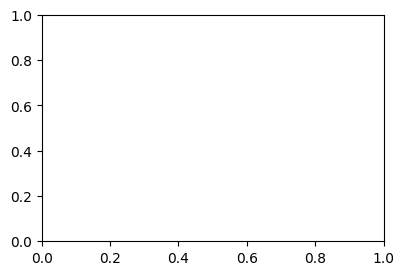

In [252]:
import matplotlib.pyplot as plt

# Assuming `pres_df` and `abs_df` are the DataFrames for presence and absence data respectively
variables = ['TCC', 'elevation', 'slope', 'aspect', 'bio06', 'bio14', 'bio18', 'bio19']

# Create histograms for each environmental variable
plt.figure(figsize=(15, 10))

for i, variable in enumerate(variables):
    plt.subplot(3, 3, i+1)  # Adjust the grid size if necessary

    # Check if the variable exists in the presence DataFrame
    if variable in pres_df.columns:
        plt.hist(pres_df[variable], bins=20, alpha=0.6, label='Presence', color='blue', edgecolor='black')

    # Check if the variable exists in the absence DataFrame
    if variable in abs_df.columns:
        plt.hist(abs_df[variable], bins=20, alpha=0.6, label='Absence', color='red', edgecolor='black')

    # Set the title and labels
    plt.title(f"Histogram of {variable}")
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


# **CHANGE LATER (TO ALSO USE GBM, LIGHT GBM, LOGISTIC REGRESSION)** Random Forest Model

In [196]:
# ──────────────────────────────────────────────────────────────────────────────
# (C)  Adapted sdm(x): use fold==3 as held‐out test, folds 0,1,2 for training
# ──────────────────────────────────────────────────────────────────────────────

def sdm(x):
    # We still accept a “seed” so that later randomForest calls are reproducible,
    # but the train/test split is now deterministic (checkerboard).
    seed = ee.Number(x)

    # 1) Define train_grid = all tiles with fold != 3, test_grid = fold == 3
    train_grid = grid_final.filter(ee.Filter.neq('fold', 3))
    test_grid  = grid_final.filter(ee.Filter.eq('fold', 3))

    # 2) Presence points (each tagged PresAbs=1)
    presence_points = ee.FeatureCollection(data).map(lambda f: f.set("PresAbs", 1))
    tr_presence_points = presence_points.filterBounds(train_grid)
    te_presence_points = presence_points.filterBounds(test_grid)

    # 3) Pseudo‐absence for training: sample from area_for_pa clipped to train_grid
    tr_pseudo_abs_points = area_for_pa.sample(
        region=train_grid,
        scale=grid_size,
        numPixels=tr_presence_points.size().add(300),
        seed=seed,
        geometries=True
    ).randomColumn("random").sort("random") \
     .limit(ee.Number(tr_presence_points.size())) \
     .map(lambda f: f.set("PresAbs", 0))

    # 4) Pseudo‐absence for testing: same logic but clipped to test_grid
    te_pseudo_abs_points = area_for_pa.sample(
        region=test_grid,
        scale=grid_size,
        numPixels=te_presence_points.size().add(100),
        seed=seed,
        geometries=True
    ).randomColumn("random").sort("random") \
     .limit(ee.Number(te_presence_points.size())) \
     .map(lambda f: f.set("PresAbs", 0))

    # 5) Merge into final train/test partitions
    training_partition = tr_presence_points.merge(tr_pseudo_abs_points)
    testing_partition  = te_presence_points.merge(te_pseudo_abs_points)

    # 6) Sample predictor values at training points
    train_pvals = predictors.sampleRegions(
        collection=training_partition,
        properties=["PresAbs"],
        scale=grid_size,
        geometries=True
    )

    # 7) Train a Random Forest model to predict Probability
    classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500,
        variablesPerSplit=None,
        minLeafPopulation=10,
        bagFraction=0.5,
        maxNodes=None,
        seed=seed
    )

    # 7a) Probability output
    classifier_pr = classifier.setOutputMode("PROBABILITY").train(
        train_pvals, "PresAbs", bands
    )
    classified_img_pr = predictors.select(bands).classify(classifier_pr)

    # 7b) Binary classification output
    classifier_bin = classifier.setOutputMode("CLASSIFICATION").train(
        train_pvals, "PresAbs", bands
    )
    classified_img_bin = predictors.select(bands).classify(classifier_bin)

    return [
        classified_img_pr,
        classified_img_bin,
        training_partition,
        testing_partition,
    ], classifier_pr

# ──────────────────────────────────────────────────────────────────────────────
# (D)  RUN YOUR ITERATIONS EXACTLY AS BEFORE
# ──────────────────────────────────────────────────────────────────────────────

split = 0.7   # (no longer used for splitting but kept for compatibility)
numiter = 10

# Generate 10 “seeds” for the Random Forests (split is deterministic)
runif = lambda length: [random.randint(1, 1000) for _ in range(length)]
items = runif(numiter)

results_list = []      # will hold [prob, binary, trainPts, testPts] for each iteration
importances_list = []  # will hold variable importance from each trained RF

for item in items:
    (result, trained) = sdm(item)
    # “result” is a list: [classified_img_pr, classified_img_bin, training_partition, testing_partition]
    results_list.extend(result)

    # Extract RF variable importance
    importance = ee.Dictionary(trained.explain()).get("importance")
    importances_list.extend(importance.getInfo().items())

# Flatten the results into a single ee.List if needed
results = ee.List(results_list).flatten()


In [249]:
results

In [197]:
import ee
import geemap
import pandas as pd
import numpy as np
import json # For parsing .geo if it's a string
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

# Ensure ee is initialized if you are running this part of the script independently
# try:
#     if not ee.data._credentials: # Check if already initialized
#         ee.Authenticate(auth_mode='notebook')
#         ee.Initialize(project='your-project-id') # Replace with your project ID
# except Exception as e:
#     print(f"Earth Engine not initialized or error during re-check: {e}")
#     # Fallback or ensure it's initialized before this point in your main script flow

# --- MODIFIED sample_probabilities FUNCTION ---
def sample_probabilities(prob_img, pts_fc, scale):
    """
    Sample the correct “presence‐probability” band from prob_img at each point.
    prob_img may have either:
      • Two bands: "0" (absence prob) and "1" (presence prob), OR
      • A single band (already the presence probability, often named 'classification').
    This function selects or renames the band to "probability", then samples at pts_fc.
    Returns a pandas.DataFrame with columns ['PresAbs', 'probability'] and coordinate columns.
    """
    # Initial checks for valid inputs
    if not isinstance(prob_img, ee.Image):
        print(f"Warning: prob_img is not an ee.Image. Type: {type(prob_img)}. Cannot sample.")
        return pd.DataFrame()
    if not isinstance(pts_fc, ee.FeatureCollection):
        print(f"Warning: pts_fc is not an ee.FeatureCollection. Type: {type(pts_fc)}. Cannot sample.")
        return pd.DataFrame()

    # Check if pts_fc is empty before calling getInfo() where possible, or handle errors
    try:
        if pts_fc.size().getInfo() == 0:
            # print("Debug: pts_fc is empty. Cannot sample.")
            return pd.DataFrame()
    except Exception as e:
        # print(f"Debug: Error checking pts_fc size: {e}. Assuming it might be invalid or empty.")
        return pd.DataFrame()

    # Check if prob_img has bands
    try:
        bands_img = prob_img.bandNames()
        if bands_img.length().getInfo() == 0:
            # print(f"Debug: prob_img has no bands. Cannot sample.")
            return pd.DataFrame()
    except Exception as e:
        # print(f"Debug: Error getting band names from prob_img: {e}. Assuming invalid image.")
        return pd.DataFrame()

    n_bands_img = bands_img.length()

    # Server-side conditional logic for band selection
    def select_prob_band(img, band_names_list, num_bands_ee_number):
        is_prob_band_present = band_names_list.contains('probability')
        is_classification_band_present = band_names_list.contains('classification')

        img_selected_prob1 = img.select(['probability'])
        img_selected_prob2 = img.select([ee.String(band_names_list.get(1))]).rename(['probability'])
        img_selected_prob3 = img.select(['classification']).rename(['probability'])
        img_selected_prob4 = img.select([ee.String(band_names_list.get(0))]).rename(['probability'])

        selected_image = ee.Image(ee.Algorithms.If(
            is_prob_band_present,
            img_selected_prob1,
            ee.Algorithms.If(
                num_bands_ee_number.eq(2),
                img_selected_prob2,
                ee.Algorithms.If(
                    is_classification_band_present,
                    img_selected_prob3,
                    img_selected_prob4
                )
            )
        ))
        return selected_image

    prob_sel = select_prob_band(prob_img, bands_img, n_bands_img)

    # Sample regions
    try:
        sampled = prob_sel.sampleRegions(
            collection=pts_fc,
            properties=['PresAbs'],
            scale=scale,
            geometries=True,  # Key change to include geometries
            tileScale=4 # Helps with large computations
        )
    except Exception as e:
        # print(f"Debug: Error during sampleRegions: {e}")
        return pd.DataFrame()

    # Convert to pandas DataFrame
    try:
        df = geemap.ee_to_df(sampled)
    except Exception as e:
        # print(f"Debug: Error converting to DataFrame with geemap.ee_to_df: {e}")
        return pd.DataFrame()

    # Validate DataFrame structure
    required_cols = ['probability', 'PresAbs']
    if not all(col in df.columns for col in required_cols):
        # print(f"Debug: DataFrame from sampleRegions is missing required columns. Found: {df.columns.tolist()}")
        # Add missing columns with NaN to prevent downstream errors
        for col_to_check in required_cols:
            if col_to_check not in df.columns:
                df[col_to_check] = np.nan

    df = df.dropna(subset=required_cols) # Drop rows if key values are NaN

    if not df.empty:
        if 'PresAbs' in df.columns:
          df['PresAbs'] = df['PresAbs'].astype(int)
        if 'probability' in df.columns:
          df['probability'] = df['probability'].astype(float)
    return df

# --- NEW HELPER FUNCTION for printing coordinates ---
def print_coordinates_for_category(df_category, category_name, run_idx, data_type_str):
    """
    Prints coordinates for a given category (TP, FP, TN, FN).
    df_category: DataFrame filtered for the specific category.
    category_name: String name of the category (e.g., "True Positives (TP)").
    run_idx: Integer, the current run/iteration number.
    data_type_str: String, "Training" or "Test".
    """
    print(f"    {category_name}:")
    if not df_category.empty:
        # Check for standard longitude/latitude columns first
        if 'longitude' in df_category.columns and 'latitude' in df_category.columns:
            for _, row in df_category.iterrows():
                if pd.notna(row['longitude']) and pd.notna(row['latitude']):
                    print(f"      Lon: {row['longitude']:.5f}, Lat: {row['latitude']:.5f}")
        # Fallback to '.geo' column if longitude/latitude are not present
        elif '.geo' in df_category.columns:
            for _, row in df_category.iterrows():
                geo_data = row['.geo']
                if pd.isna(geo_data): continue # Skip if geo_data is NaN

                if isinstance(geo_data, str): # If .geo is a string, try to parse as JSON
                    try:
                        geo_data = json.loads(geo_data.replace("'", "\"")) # Handle single quotes
                    except json.JSONDecodeError:
                        # print(f"      Warning: Could not parse .geo string: {geo_data}")
                        continue

                # Check if parsed/original geo_data is a dict with 'coordinates'
                if isinstance(geo_data, dict) and 'coordinates' in geo_data and \
                   isinstance(geo_data['coordinates'], list) and len(geo_data['coordinates']) == 2 and \
                   pd.notna(geo_data['coordinates'][0]) and pd.notna(geo_data['coordinates'][1]):
                    print(f"      Lon: {geo_data['coordinates'][0]:.5f}, Lat: {geo_data['coordinates'][1]:.5f}")
                # else:
                    # print(f"      Warning: Coordinates format in '.geo' not as expected or NaN: {geo_data}")
        else:
            # print(f"      Warning: Coordinate columns ('longitude', 'latitude', or '.geo') not found in DataFrame for {category_name}, Run {run_idx}, {data_type_str}.")
            # print(f"      Available columns: {df_category.columns.tolist()}")
            pass # Suppress if too verbose
    else:
        print("      None")


# --- MODIFIED METRICS CALCULATION LOOP ---
# Ensure numiter and results are defined before this loop
# Example: numiter = 10 (should be defined earlier in your script)
# Example: results = ee.List([...]) (should be populated by your sdm function calls)

metrics_all_runs = [] # Initialize list to store metrics for all runs

# Assuming 'numiter' and 'results' (the ee.List) are defined and populated
# from the model training part of your script.
if 'numiter' in locals() and 'results' in locals() and isinstance(results, ee.List) and results.size().getInfo() >= numiter * 4 :
    for i_run in range(numiter):
        idx_prob_img = 4 * i_run
        idx_tr_pts   = 4 * i_run + 2
        idx_te_pts   = 4 * i_run + 3

        current_run_metrics_dict = {
            'run': i_run + 1,
            'train_tn': np.nan, 'train_fp': np.nan, 'train_fn': np.nan, 'train_tp': np.nan,
            'train_accuracy': np.nan, 'train_recall': np.nan, 'train_precision': np.nan,
            'train_f1': np.nan, 'train_auc': np.nan,
            'test_tn': np.nan, 'test_fp': np.nan, 'test_fn': np.nan, 'test_tp': np.nan,
            'test_accuracy': np.nan, 'test_recall': np.nan, 'test_precision': np.nan,
            'test_f1': np.nan, 'test_auc': np.nan,
        }

        prob_img_current = ee.Image(results.get(idx_prob_img))
        tr_points_current = ee.FeatureCollection(results.get(idx_tr_pts))
        te_points_current = ee.FeatureCollection(results.get(idx_te_pts))

        # ─── TRAINING METRICS ────────────────────────────────────────────────────
        df_tr_sampled = sample_probabilities(prob_img_current, tr_points_current, grid_size)

        if df_tr_sampled.empty or not all(col in df_tr_sampled.columns for col in ['PresAbs', 'probability']) or df_tr_sampled[['PresAbs', 'probability']].isnull().values.any():
            print(f"Run {i_run+1}: Training data is empty or invalid after sampling; skipping training metrics and coordinate printing.")
        else:
            y_true_tr_vals = df_tr_sampled['PresAbs'].values
            y_prob_tr_vals = df_tr_sampled['probability'].values
            # Ensure there are probabilities to make predictions from
            if pd.Series(y_prob_tr_vals).notna().all() and len(y_prob_tr_vals) > 0:
                y_pred_tr_vals = (y_prob_tr_vals >= 0.5).astype(int)
                df_tr_sampled['prediction'] = y_pred_tr_vals

                try:
                    # Ensure y_true_tr_vals and y_pred_tr_vals are not empty and have compatible shapes
                    if len(y_true_tr_vals) > 0 and len(y_true_tr_vals) == len(y_pred_tr_vals):
                        cm_tr_val = confusion_matrix(y_true_tr_vals, y_pred_tr_vals, labels=[0, 1])
                        if len(cm_tr_val.ravel()) == 4: # Check if confusion matrix is 2x2
                            tn_tr_val, fp_tr_val, fn_tr_val, tp_tr_val = cm_tr_val.ravel()
                            current_run_metrics_dict.update({
                                'train_tn': int(tn_tr_val), 'train_fp': int(fp_tr_val),
                                'train_fn': int(fn_tr_val), 'train_tp': int(tp_tr_val),
                                'train_accuracy': float(accuracy_score(y_true_tr_vals, y_pred_tr_vals)),
                                'train_recall': float(recall_score(y_true_tr_vals, y_pred_tr_vals, zero_division=0)),
                                'train_precision': float(precision_score(y_true_tr_vals, y_pred_tr_vals, zero_division=0)),
                                'train_f1': float(f1_score(y_true_tr_vals, y_pred_tr_vals, zero_division=0)),
                            })
                            if len(np.unique(y_true_tr_vals)) > 1: # AUC requires at least two classes in y_true
                                current_run_metrics_dict['train_auc'] = float(roc_auc_score(y_true_tr_vals, y_prob_tr_vals))
                            else:
                                current_run_metrics_dict['train_auc'] = np.nan # Not enough classes for AUC
                        else:
                            print(f"Run {i_run+1}: Training confusion matrix not 2x2, was {cm_tr_val.ravel()}. Skipping detailed metrics.")
                    else:
                        print(f"Run {i_run+1}: Training y_true or y_pred is empty or mismatched. Skipping metrics calculation.")


                    # Print Coordinates for Training Data
                    print(f"\n--- Run {i_run+1} - Training Data Point Coordinates ---")
                    # Ensure 'prediction' column exists before filtering
                    if 'prediction' in df_tr_sampled.columns:
                        TP_tr_df_coords = df_tr_sampled[(df_tr_sampled['PresAbs'] == 1) & (df_tr_sampled['prediction'] == 1)]
                        FP_tr_df_coords = df_tr_sampled[(df_tr_sampled['PresAbs'] == 0) & (df_tr_sampled['prediction'] == 1)]
                        TN_tr_df_coords = df_tr_sampled[(df_tr_sampled['PresAbs'] == 0) & (df_tr_sampled['prediction'] == 0)]
                        FN_tr_df_coords = df_tr_sampled[(df_tr_sampled['PresAbs'] == 1) & (df_tr_sampled['prediction'] == 0)]

                        print_coordinates_for_category(TP_tr_df_coords, "True Positives (TP)", i_run + 1, "Training")
                        print_coordinates_for_category(FP_tr_df_coords, "False Positives (FP)", i_run + 1, "Training")
                        print_coordinates_for_category(TN_tr_df_coords, "True Negatives (TN)", i_run + 1, "Training")
                        print_coordinates_for_category(FN_tr_df_coords, "False Negatives (FN)", i_run + 1, "Training")
                    else:
                        print(f"Run {i_run+1}: 'prediction' column missing in training DataFrame. Cannot print coordinates by category.")

                except ValueError as ve:
                    print(f"Run {i_run+1}: Error calculating training metrics: {ve}")
                except Exception as e_gen:
                    print(f"Run {i_run+1}: General error during training metrics/coordinates: {e_gen}")
            else:
                print(f"Run {i_run+1}: Training probabilities are NaN or empty. Skipping prediction and metrics.")


        # ─── TEST METRICS ───────────────────────────────────────────────────────
        df_te_sampled = sample_probabilities(prob_img_current, te_points_current, grid_size)

        if df_te_sampled.empty or not all(col in df_te_sampled.columns for col in ['PresAbs', 'probability']) or df_te_sampled[['PresAbs', 'probability']].isnull().values.any():
            print(f"Run {i_run+1}: Test data is empty or invalid after sampling; skipping test metrics and coordinate printing.")
        else:
            y_true_te_vals = df_te_sampled['PresAbs'].values
            y_prob_te_vals = df_te_sampled['probability'].values
            if pd.Series(y_prob_te_vals).notna().all() and len(y_prob_te_vals) > 0:
                y_pred_te_vals = (y_prob_te_vals >= 0.5).astype(int)
                df_te_sampled['prediction'] = y_pred_te_vals

                try:
                    if len(y_true_te_vals) > 0 and len(y_true_te_vals) == len(y_pred_te_vals):
                        cm_te_val = confusion_matrix(y_true_te_vals, y_pred_te_vals, labels=[0, 1])
                        if len(cm_te_val.ravel()) == 4:
                            tn_te_val, fp_te_val, fn_te_val, tp_te_val = cm_te_val.ravel()
                            current_run_metrics_dict.update({
                                'test_tn': int(tn_te_val), 'test_fp': int(fp_te_val),
                                'test_fn': int(fn_te_val), 'test_tp': int(tp_te_val),
                                'test_accuracy': float(accuracy_score(y_true_te_vals, y_pred_te_vals)),
                                'test_recall': float(recall_score(y_true_te_vals, y_pred_te_vals, zero_division=0)),
                                'test_precision': float(precision_score(y_true_te_vals, y_pred_te_vals, zero_division=0)),
                                'test_f1': float(f1_score(y_true_te_vals, y_pred_te_vals, zero_division=0)),
                            })
                            if len(np.unique(y_true_te_vals)) > 1:
                                current_run_metrics_dict['test_auc'] = float(roc_auc_score(y_true_te_vals, y_prob_te_vals))
                            else:
                                current_run_metrics_dict['test_auc'] = np.nan
                        else:
                            print(f"Run {i_run+1}: Test confusion matrix not 2x2, was {cm_te_val.ravel()}. Skipping detailed metrics.")
                    else:
                        print(f"Run {i_run+1}: Test y_true or y_pred is empty or mismatched. Skipping metrics calculation.")

                    print(f"\n--- Run {i_run+1} - Test Data Point Coordinates ---")
                    if 'prediction' in df_te_sampled.columns:
                        TP_te_df_coords = df_te_sampled[(df_te_sampled['PresAbs'] == 1) & (df_te_sampled['prediction'] == 1)]
                        FP_te_df_coords = df_te_sampled[(df_te_sampled['PresAbs'] == 0) & (df_te_sampled['prediction'] == 1)]
                        TN_te_df_coords = df_te_sampled[(df_te_sampled['PresAbs'] == 0) & (df_te_sampled['prediction'] == 0)]
                        FN_te_df_coords = df_te_sampled[(df_te_sampled['PresAbs'] == 1) & (df_te_sampled['prediction'] == 0)]

                        print_coordinates_for_category(TP_te_df_coords, "True Positives (TP)", i_run + 1, "Test")
                        print_coordinates_for_category(FP_te_df_coords, "False Positives (FP)", i_run + 1, "Test")
                        print_coordinates_for_category(TN_te_df_coords, "True Negatives (TN)", i_run + 1, "Test")
                        print_coordinates_for_category(FN_te_df_coords, "False Negatives (FN)", i_run + 1, "Test")
                    else:
                        print(f"Run {i_run+1}: 'prediction' column missing in test DataFrame. Cannot print coordinates by category.")

                except ValueError as ve:
                    print(f"Run {i_run+1}: Error calculating test metrics: {ve}")
                except Exception as e_gen:
                    print(f"Run {i_run+1}: General error during test metrics/coordinates: {e_gen}")
            else:
                print(f"Run {i_run+1}: Test probabilities are NaN or empty. Skipping prediction and metrics.")

        metrics_all_runs.append(current_run_metrics_dict)

    metrics_df_final = pd.DataFrame(metrics_all_runs)
    print("\n--- All Run Metrics (Final DataFrame) ---")
    print(metrics_df_final)
else:
    print("Error: 'numiter' or 'results' (the ee.List from sdm function) not defined or results list is too short. Skipping metrics calculation loop.")
    # Initialize metrics_df_final as empty if the loop is skipped
    metrics_df_final = pd.DataFrame()


# To display the DataFrame at the end if in a notebook
# print(metrics_df_final) # Or just metrics_df_final if it's the last line in a cell



--- Run 1 - Training Data Point Coordinates ---
    True Positives (TP):
    False Positives (FP):
    True Negatives (TN):
    False Negatives (FN):

--- Run 1 - Test Data Point Coordinates ---
    True Positives (TP):
    False Positives (FP):
    True Negatives (TN):
    False Negatives (FN):

--- Run 2 - Training Data Point Coordinates ---
    True Positives (TP):
    False Positives (FP):
    True Negatives (TN):
    False Negatives (FN):

--- Run 2 - Test Data Point Coordinates ---
    True Positives (TP):
    False Positives (FP):
      None
    True Negatives (TN):
    False Negatives (FN):

--- Run 3 - Training Data Point Coordinates ---
    True Positives (TP):
    False Positives (FP):
    True Negatives (TN):
    False Negatives (FN):

--- Run 3 - Test Data Point Coordinates ---
    True Positives (TP):
    False Positives (FP):
      None
    True Negatives (TN):
    False Negatives (FN):

--- Run 4 - Training Data Point Coordinates ---
    True Positives (TP):
    False 

In [198]:
print(metrics_df_final)

   run  train_tn  train_fp  train_fn  train_tp  train_accuracy  train_recall  \
0    1        75         4        17        62        0.867089      0.784810   
1    2        77         2        16        63        0.886076      0.797468   
2    3        74         5        18        61        0.854430      0.772152   
3    4        76         3        17        62        0.873418      0.784810   
4    5        74         5        17        62        0.860759      0.784810   
5    6        77         2        17        62        0.879747      0.784810   
6    7        78         1        17        62        0.886076      0.784810   
7    8        76         3        16        63        0.879747      0.797468   
8    9        77         2        17        62        0.879747      0.784810   
9   10        75         4        17        62        0.867089      0.784810   

   train_precision  train_f1  train_auc  test_tn  test_fp  test_fn  test_tp  \
0         0.939394  0.855172   0.944881 

In [254]:
# Assuming your DataFrame is named 'metrics_df_final'
# Calculate the mean for each column

average_metrics = metrics_df_final.mean()

# Print the averages
print("Average Metrics:")
print(average_metrics)


Average Metrics:
run                 5.500000
train_tn           75.900000
train_fp            3.100000
train_fn           16.900000
train_tp           62.100000
train_accuracy      0.873418
train_recall        0.786076
train_precision     0.952765
train_f1            0.861362
train_auc           0.954591
test_tn            13.400000
test_fp             0.600000
test_fn             3.100000
test_tp            10.900000
test_accuracy       0.867857
test_recall         0.778571
test_precision      0.951282
test_f1             0.855276
test_auc            0.920408
dtype: float64


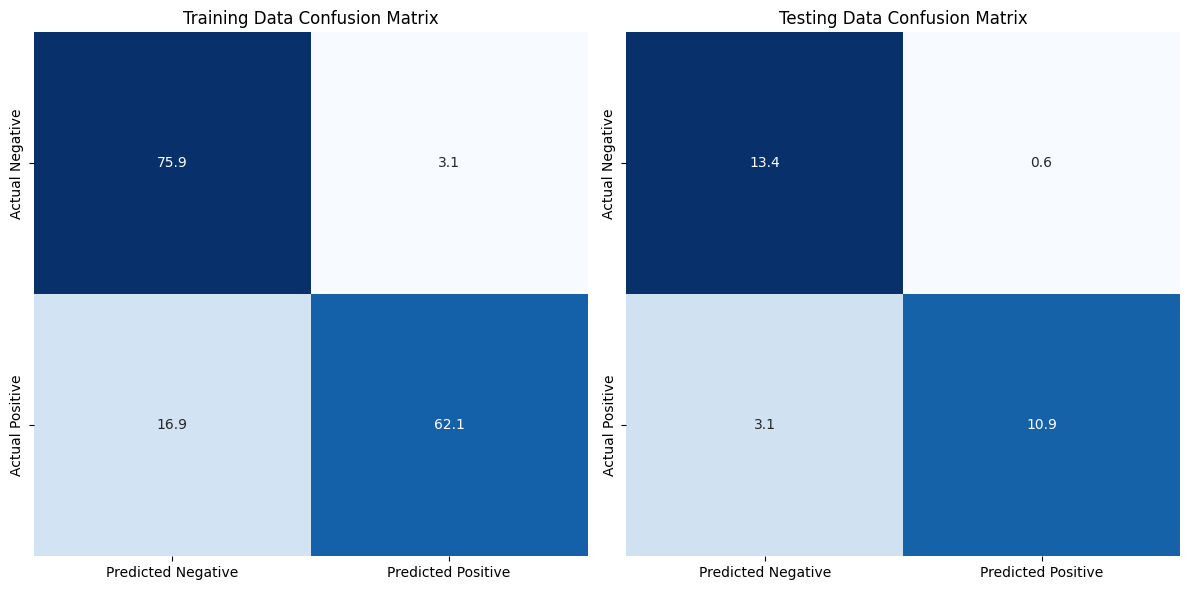

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract confusion matrix values from metrics_df_final
train_tn = metrics_df_final['train_tn'].values
train_fp = metrics_df_final['train_fp'].values
train_fn = metrics_df_final['train_fn'].values
train_tp = metrics_df_final['train_tp'].values

test_tn = metrics_df_final['test_tn'].values
test_fp = metrics_df_final['test_fp'].values
test_fn = metrics_df_final['test_fn'].values
test_tp = metrics_df_final['test_tp'].values

# Create confusion matrices for both train and test data
train_conf_matrix = np.array([[train_tn.mean(), train_fp.mean()],
                              [train_fn.mean(), train_tp.mean()]])

test_conf_matrix = np.array([[test_tn.mean(), test_fp.mean()],
                             [test_fn.mean(), test_tp.mean()]])

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training confusion matrix
sns.heatmap(train_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], ax=axes[0])
axes[0].set_title("Training Data Confusion Matrix")

# Plot testing confusion matrix
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], ax=axes[1])
axes[1].set_title("Testing Data Confusion Matrix")

# Display the plot
plt.tight_layout()
plt.show()


# Habitat Suitability Map

In [199]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geemap

# 1) Compute model_average as before
images = ee.List.sequence(
    0, ee.Number(numiter).multiply(4).subtract(1), 4
).map(lambda x: results.get(x))
model_average = ee.ImageCollection.fromImages(images).mean()

# 2) Build a 256‐step (normal) Viridis palette in hex using matplotlib
viridis = plt.cm.viridis  # Use matplotlib's Viridis colormap
palette = [mcolors.rgb2hex(viridis(i / 255.)) for i in range(256)]  # Normalize to [0,1]

# 3) Set up the map
Map = geemap.Map(
    layout={'height': '400px', 'width': '800px'},
    basemap='Esri.WorldImagery'
)

# 4) Add habitat suitability with higher = yellow
vis_params = {
    'min': 0,
    'max': 1,
    'palette': palette
}
Map.addLayer(model_average, vis_params, 'Habitat suitability')
Map.add_colorbar(
    vis_params,
    label="Habitat suitability",
    orientation="horizontal",
    layer_name="Habitat suitability"
)

# 5) Add presence points
Map.addLayer(data, {'color': 'red'}, 'Presence')

# 6) Load & style country borders
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
country_borders = countries.style(
    color='000000',
    fillColor='00000000',
    width=1
)
Map.addLayer(country_borders, {}, 'Country borders')

# 7) Center & display
Map.centerObject(aoi, 6)
Map


Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

# Potential Distribution Map

In [200]:
# Potential distribution map
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(
    lambda x: results.get(x)
)
distribution_map = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map(
    layout={"height": "400px", "width": "800px"}, basemap="Esri.WorldImagery"
)

vis_params = {"min": 0, "max": 1, "palette": ["white", "green"]}
Map.addLayer(distribution_map, vis_params, "Potential distribution")
Map.addLayer(data, {"color": "red"}, "Presence")
Map.add_colorbar(
    vis_params,
    label="Potential distribution",
    discrete=True,
    orientation="horizontal",
    layer_name="Potential distribution",
)

countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
country_borders = countries.style(
    color='000000',
    fillColor='00000000',
    width=1
)
Map.addLayer(country_borders, {}, 'Country borders')

Map.centerObject(data.geometry(), 6)
Map

Map(center=[13.694961404214716, 106.32259424948586], controls=(WidgetControl(options=['position', 'transparent…

#**NEW** bioclimatic envelope baseline method

In [231]:
# Compute min/max TCC values for presence points in folds 0, 1, 2
presence_folds_0_1_2 = presence_with_folds.filter(
    ee.Filter.inList('fold', [0, 1, 2])
)


# Sample the TCC values at the presence points
tcc_samples = predictors.select('TCC').sampleRegions(
    collection=presence_folds_0_1_2,
    scale=grid_size,
    geometries=True
)

# Compute min and max TCC from the sampled points
tcc_min_max = tcc_samples.reduceColumns(
    reducer=ee.Reducer.minMax(),
    selectors=['TCC']
)

# Get the min and max values
tcc_min = tcc_min_max.get('min').getInfo()
tcc_max = tcc_min_max.get('max').getInfo()

print(f"TCC Min (folds 0,1,2, presence only): {tcc_min}")
print(f"TCC Max (folds 0,1,2, presence only): {tcc_max}")

# Sample the elevation values at the presence points
elevation_samples = predictors.select('elevation').sampleRegions(
    collection=presence_folds_0_1_2,
    scale=grid_size,
    geometries=True
)

# Compute min and max TCC from the sampled points
elevation_min_max = elevation_samples.reduceColumns(
    reducer=ee.Reducer.minMax(),
    selectors=['elevation']
)

# Get the min and max values
elevation_min = elevation_min_max.get('min').getInfo()
elevation_max = elevation_min_max.get('max').getInfo()

print(f"Elevation Min (folds 0,1,2, presence only): {elevation_min}")
print(f"Elevation Max (folds 0,1,2, presence only): {elevation_max}")


TCC Min (folds 0,1,2, presence only): 12
TCC Max (folds 0,1,2, presence only): 78
Elevation Min (folds 0,1,2, presence only): 72
Elevation Max (folds 0,1,2, presence only): 1437


In [234]:
import geemap
import ee

# Step 1: Define the range for TCC and elevation based on the min/max values
tcc_min_value = tcc_min  # Min value for TCC
tcc_max_value = tcc_max  # Max value for TCC

elevation_min_value = elevation_min  # Min value for Elevation
elevation_max_value = elevation_max  # Max value for Elevation

# Step 2: Create a mask for TCC
tcc_mask = predictors.select('TCC').gte(tcc_min_value).And(predictors.select('TCC').lte(tcc_max_value))

# Step 3: Create a mask for Elevation
elevation_mask = predictors.select('elevation').gte(elevation_min_value).And(predictors.select('elevation').lte(elevation_max_value))

# Step 4: Combine the TCC and Elevation masks (areas that meet both conditions)
combined_mask = tcc_mask.And(elevation_mask)

# Step 5: Clip the mask to the area of interest (AOI) to ensure that it doesn't go beyond the study area
combined_mask_clipped = combined_mask.clip(aoi)

# Step 6: Plot the map with the combined mask
Map = geemap.Map(layout={'height': '400px', 'width': '800px'}, basemap='Esri.WorldImagery')

# Add the mask to the map
Map.addLayer(combined_mask_clipped, {'palette': ['black', 'green'], 'opacity': 0.5}, 'Masked Areas (TCC & Elevation)')

# Step 7: Add the presence points (red) for context
# Check if the 'data' variable is a FeatureCollection or geometry object
if isinstance(data, ee.FeatureCollection):
    Map.addLayer(data, {'color': 'red'}, 'Presence Points')

# Step 8: Add country borders for reference
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
country_borders = countries.style(
    color='000000',
    fillColor='00000000',
    width=1
)
Map.addLayer(country_borders, {}, 'Country borders')

# Center the map around the AOI
Map.centerObject(aoi, 6)

# Step 9: Save the map result (export as GeoTIFF or save it locally)
# Export the combined mask to Google Drive (you can specify other export parameters as needed)
export_task = ee.batch.Export.image.toDrive(
    image=combined_mask_clipped,
    description='combined_mask_tcc_elevation',
    scale=1000,  # Resolution in meters (adjust as needed)
    region=aoi.bounds().getInfo()['coordinates'],  # Use bounds directly here
    fileFormat='GeoTIFF',
    maxPixels=1e8
)

# Start the export task
export_task.start()

# Display the map
Map


Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [237]:
# Step 0: Define variables to store min and max values for each environmental variable
tcc_min = None
tcc_max = None

elevation_min = None
elevation_max = None

slope_min = None
slope_max = None

aspect_min = None
aspect_max = None

bio06_min = None
bio06_max = None

bio14_min = None
bio14_max = None

bio18_min = None
bio18_max = None

bio19_min = None
bio19_max = None

# Step 1: Filter the presence points in folds 0, 1, and 2
presence_folds_0_1_2 = presence_with_folds.filter(
    ee.Filter.inList('fold', [0, 1, 2])
)

# Step 2: Initialize a dictionary to store min/max values for each variable
min_max_values = {}

# Step 3: Loop through each environmental variable and compute min/max values
for variable in variables:
    # Sample the variable values at the presence points
    variable_samples = predictors.select(variable).sampleRegions(
        collection=presence_folds_0_1_2,
        scale=grid_size,
        geometries=True
    )

    # Compute min and max of the variable
    variable_min_max = variable_samples.reduceColumns(
        reducer=ee.Reducer.minMax(),
        selectors=[variable]
    )

    # Get the min and max values
    variable_min = variable_min_max.get('min').getInfo()
    variable_max = variable_min_max.get('max').getInfo()

    # Store the results in the dictionary
    min_max_values[variable] = {'min': variable_min, 'max': variable_max}

    # Store them in respective variables
    if variable == 'TCC':
        tcc_min = variable_min
        tcc_max = variable_max
    elif variable == 'elevation':
        elevation_min = variable_min
        elevation_max = variable_max
    elif variable == 'slope':
        slope_min = variable_min
        slope_max = variable_max
    elif variable == 'aspect':
        aspect_min = variable_min
        aspect_max = variable_max
    elif variable == 'bio06':
        bio06_min = variable_min
        bio06_max = variable_max
    elif variable == 'bio14':
        bio14_min = variable_min
        bio14_max = variable_max
    elif variable == 'bio18':
        bio18_min = variable_min
        bio18_max = variable_max
    elif variable == 'bio19':
        bio19_min = variable_min
        bio19_max = variable_max

    # Print the min and max values for the current variable
    print(f"{variable} Min (folds 0,1,2, presence only): {variable_min}")
    print(f"{variable} Max (folds 0,1,2, presence only): {variable_max}")

# After the loop, `min_max_values` contains the min/max for all variables
print("All min/max values for the selected environmental variables:")
print(min_max_values)


TCC Min (folds 0,1,2, presence only): 12
TCC Max (folds 0,1,2, presence only): 78
elevation Min (folds 0,1,2, presence only): 72
elevation Max (folds 0,1,2, presence only): 1437
slope Min (folds 0,1,2, presence only): 0
slope Max (folds 0,1,2, presence only): 9
aspect Min (folds 0,1,2, presence only): 16
aspect Max (folds 0,1,2, presence only): 351
bio06 Min (folds 0,1,2, presence only): 110
bio06 Max (folds 0,1,2, presence only): 192
bio14 Min (folds 0,1,2, presence only): 0
bio14 Max (folds 0,1,2, presence only): 54
bio18 Min (folds 0,1,2, presence only): 232
bio18 Max (folds 0,1,2, presence only): 920
bio19 Min (folds 0,1,2, presence only): 36
bio19 Max (folds 0,1,2, presence only): 263
All min/max values for the selected environmental variables:
{'TCC': {'min': 12, 'max': 78}, 'elevation': {'min': 72, 'max': 1437}, 'slope': {'min': 0, 'max': 9}, 'aspect': {'min': 16, 'max': 351}, 'bio06': {'min': 110, 'max': 192}, 'bio14': {'min': 0, 'max': 54}, 'bio18': {'min': 232, 'max': 920}, '

In [243]:
import geemap
import ee
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

# Initialize Earth Engine (add this if not already done)
# ee.Initialize()

# Step 1: Define the range for each environmental variable based on the min/max values
variables_min_max = {
    'TCC': {'min': tcc_min, 'max': tcc_max},
    'elevation': {'min': elevation_min, 'max': elevation_max},
    'slope': {'min': slope_min, 'max': slope_max},
    'aspect': {'min': aspect_min, 'max': aspect_max},
    'bio06': {'min': bio06_min, 'max': bio06_max},
    'bio14': {'min': bio14_min, 'max': bio14_max},
    'bio18': {'min': bio18_min, 'max': bio18_max},
    'bio19': {'min': bio19_min, 'max': bio19_max},
}

# Step 2: Create a mask for each environmental variable
masks = []

for variable, min_max in variables_min_max.items():
    # Check if the variable exists in predictors
    try:
        var_mask = (predictors.select(variable)
                   .gte(min_max['min'])
                   .And(predictors.select(variable).lte(min_max['max'])))
        masks.append(var_mask)
        print(f"Created mask for {variable}: {min_max['min']} - {min_max['max']}")
    except Exception as e:
        print(f"Error creating mask for {variable}: {e}")

# Step 3: Combine the individual masks (overlap all conditions)
if masks:
    combined_mask = masks[0]
    for mask in masks[1:]:
        combined_mask = combined_mask.And(mask)
    print(f"Combined {len(masks)} masks successfully")
else:
    raise ValueError("No valid masks were created")

# Step 4: Clip the combined mask to the area of interest (AOI)
combined_mask_clipped = combined_mask.clip(aoi)

# Step 5: Plot the map with the combined mask
Map = geemap.Map(layout={'height': '400px', 'width': '800px'}, basemap='Esri.WorldImagery')

# Add the combined mask to the map
Map.addLayer(combined_mask_clipped,
            {'palette': ['black', 'green'], 'opacity': 0.5},
            'Masked Areas (8 Variables)')

# Step 6: Add the presence points for the test fold (red)
test_fold = presence_with_folds.filter(ee.Filter.eq('fold', 3))  # Assuming fold 3 is the test fold
Map.addLayer(test_fold, {'color': 'red'}, 'Test Fold Presence Points')

# Step 7: Add country borders for reference
try:
    countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
    country_borders = countries.style(
        color='000000',
        fillColor='00000000',
        width=1
    )
    Map.addLayer(country_borders, {}, 'Country borders')
except Exception as e:
    print(f"Warning: Could not load country borders: {e}")

# Center the map around the AOI
Map.centerObject(aoi, 6)

# Step 8: Calculate accuracy, recall, precision, and F1 score for the test fold presence points
try:
    # Sample the test fold points
    test_fold_samples = predictors.select(list(variables_min_max.keys())).sampleRegions(
        collection=test_fold,
        scale=1000,
        geometries=True
    )

    # Step 9: Extract mask values for presence points (check if they fall within the mask)
    def add_mask_value(feature):
        mask_value = combined_mask_clipped.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=feature.geometry(),
            scale=1000,
            maxPixels=1e6
        )
        # Get the first band name from the mask (should be from the first variable)
        first_band = combined_mask_clipped.bandNames().get(0)
        return feature.set('in_mask', mask_value.get(first_band))

    test_fold_samples_with_mask = test_fold_samples.map(add_mask_value)

    # Step 10: Convert test fold samples to a pandas DataFrame for evaluation
    print("Converting Earth Engine data to DataFrame...")
    test_fold_df = geemap.ee_to_df(test_fold_samples_with_mask)

    # Step 11: Calculate the metrics for the test fold presence points
    if 'PresAbs' in test_fold_df.columns and 'in_mask' in test_fold_df.columns:
        y_true = test_fold_df['PresAbs']
        # Convert mask values to binary (1 if within mask, 0 if not)
        y_pred = test_fold_df['in_mask'].fillna(0).astype(int)

        # Ensure y_pred is binary (1 for values > 0, 0 otherwise)
        y_pred = (y_pred > 0).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print("\n=== Model Performance Metrics ===")
        print(f"Recall: {recall:.4f}")

        # Additional statistics
        total_points = len(test_fold_df)
        points_in_mask = sum(y_pred)
        print(f"\nTotal test points: {total_points}")
        print(f"Points within mask: {points_in_mask}")
        print(f"Percentage within mask: {(points_in_mask/total_points)*100:.2f}%")

    else:
        print("Error: Required columns 'PresAbs' or 'in_mask' not found in DataFrame")
        print(f"Available columns: {test_fold_df.columns.tolist()}")

except Exception as e:
    print(f"Error during metric calculation: {e}")

# Step 12: Save the combined mask as a GeoTIFF
try:
    # Get the bounds of the AOI
    aoi_bounds = aoi.bounds()

    export_task = ee.batch.Export.image.toDrive(
        image=combined_mask_clipped.select([combined_mask_clipped.bandNames().get(0)]),  # Select first band
        description='combined_mask_8_variables',
        scale=1000,  # Resolution in meters
        region=aoi_bounds.getInfo()['coordinates'],
        fileFormat='GeoTIFF',
        maxPixels=1e9,  # Increased max pixels
        folder='Earth_Engine_Exports'  # Specify folder
    )

    # Start the export task
    export_task.start()
    print(f"\nExport task started: {export_task.id}")
    print("Check your Google Drive for the exported GeoTIFF file")

except Exception as e:
    print(f"Error starting export task: {e}")

# Display the map
print("\nDisplaying map...")
Map

Created mask for TCC: 12 - 78
Created mask for elevation: 72 - 1437
Created mask for slope: 0 - 9
Created mask for aspect: 16 - 351
Created mask for bio06: 110 - 192
Created mask for bio14: 0 - 54
Created mask for bio18: 232 - 920
Created mask for bio19: 36 - 263
Combined 8 masks successfully
Converting Earth Engine data to DataFrame...

=== Model Performance Metrics ===
Recall: 0.5714

Total test points: 14
Points within mask: 8
Percentage within mask: 57.14%

Export task started: MLZB5DPPC3XBKJN4MZJE5G3N
Check your Google Drive for the exported GeoTIFF file

Displaying map...


Map(center=[15.704501554435359, 105.23314411794203], controls=(WidgetControl(options=['position', 'transparent…

In [241]:
import geemap
import ee
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

# Initialize Earth Engine (add this if not already done)
# ee.Initialize()

# Step 1: Define the range for each environmental variable based on the min/max values
variables_min_max = {
    'TCC': {'min': tcc_min, 'max': tcc_max},
    'elevation': {'min': elevation_min, 'max': elevation_max},
    'slope': {'min': slope_min, 'max': slope_max},
    'aspect': {'min': aspect_min, 'max': aspect_max},
    'bio06': {'min': bio06_min, 'max': bio06_max},
    'bio14': {'min': bio14_min, 'max': bio14_max},
    'bio18': {'min': bio18_min, 'max': bio18_max},
    'bio19': {'min': bio19_min, 'max': bio19_max},
}

# Step 2: Create a mask for each environmental variable
masks = []

for variable, min_max in variables_min_max.items():
    # Check if the variable exists in predictors
    try:
        var_mask = (predictors.select(variable)
                   .gte(min_max['min'])
                   .And(predictors.select(variable).lte(min_max['max'])))
        masks.append(var_mask)
        print(f"Created mask for {variable}: {min_max['min']} - {min_max['max']}")
    except Exception as e:
        print(f"Error creating mask for {variable}: {e}")

# Step 3: Combine the individual masks (overlap all conditions)
if masks:
    combined_mask = masks[0]
    for mask in masks[1:]:
        combined_mask = combined_mask.And(mask)
    print(f"Combined {len(masks)} masks successfully")
else:
    raise ValueError("No valid masks were created")

# Step 4: Clip the combined mask to the area of interest (AOI)
combined_mask_clipped = combined_mask.clip(aoi)

# Step 5: Plot the map with the combined mask
Map = geemap.Map(layout={'height': '400px', 'width': '800px'}, basemap='Esri.WorldImagery')

# Add the combined mask to the map
Map.addLayer(combined_mask_clipped,
            {'palette': ['black', 'green'], 'opacity': 0.5},
            'Masked Areas (8 Variables)')

presence_with_folds = data.map(lambda f: f.set('PresAbs', 1)).map(assign_fold_to_point)
absence_with_folds = data.map(lambda f: f.set('PresAbs', 0)).map(assign_fold_to_point)

# Step 6: Add both presence and absence points for the test fold
test_fold_presence = presence_with_folds.filter(ee.Filter.eq('fold', 3))  # Test fold presence points
test_fold_absence = absence_with_folds.filter(ee.Filter.eq('fold', 3))   # Test fold absence points

# Combine presence and absence points for complete test dataset
test_fold_combined = test_fold_presence.merge(test_fold_absence)

Map.addLayer(test_fold_presence, {'color': 'red'}, 'Test Fold Presence Points')
Map.addLayer(test_fold_absence, {'color': 'blue'}, 'Test Fold Absence Points')

# Step 7: Add country borders for reference
try:
    countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
    country_borders = countries.style(
        color='000000',
        fillColor='00000000',
        width=1
    )
    Map.addLayer(country_borders, {}, 'Country borders')
except Exception as e:
    print(f"Warning: Could not load country borders: {e}")

# Center the map around the AOI
Map.centerObject(aoi, 6)

# Step 8: Calculate accuracy, recall, precision, and F1 score for all test fold points (presence + absence)
try:
    # Sample both presence and absence points from the test fold
    test_fold_samples = predictors.select(list(variables_min_max.keys())).sampleRegions(
        collection=test_fold_combined,  # Use combined presence + absence points
        scale=1000,
        geometries=True
    )

    # Step 9: Extract mask values for all points (presence + absence)
    def add_mask_value(feature):
        mask_value = combined_mask_clipped.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=feature.geometry(),
            scale=1000,
            maxPixels=1e6
        )
        # Get the first band name from the mask (should be from the first variable)
        first_band = combined_mask_clipped.bandNames().get(0)
        return feature.set('in_mask', mask_value.get(first_band))

    test_fold_samples_with_mask = test_fold_samples.map(add_mask_value)

    # Step 10: Convert test fold samples to a pandas DataFrame for evaluation
    print("Converting Earth Engine data to DataFrame...")
    test_fold_df = geemap.ee_to_df(test_fold_samples_with_mask)

    # Step 11: Calculate the metrics for all test fold points (presence + absence)
    if 'PresAbs' in test_fold_df.columns and 'in_mask' in test_fold_df.columns:
        y_true = test_fold_df['PresAbs']  # True labels (1 for presence, 0 for absence)
        # Convert mask values to binary (1 if within mask, 0 if not)
        y_pred = test_fold_df['in_mask'].fillna(0).astype(int)

        # Ensure y_pred is binary (1 for values > 0, 0 otherwise)
        y_pred = (y_pred > 0).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print("\n=== Model Performance Metrics ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Recall (Sensitivity): {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Calculate additional metrics
        from sklearn.metrics import confusion_matrix, classification_report

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate specificity (True Negative Rate)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"Specificity: {specificity:.4f}")

        print("\n=== Confusion Matrix ===")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Positives (TP): {tp}")

        # Detailed breakdown
        total_points = len(test_fold_df)
        presence_points = sum(y_true)
        absence_points = total_points - presence_points
        points_in_mask = sum(y_pred)

        print(f"\n=== Data Summary ===")
        print(f"Total test points: {total_points}")
        print(f"Presence points: {presence_points}")
        print(f"Absence points: {absence_points}")
        print(f"Points predicted as suitable (in mask): {points_in_mask}")
        print(f"Points predicted as unsuitable (out of mask): {total_points - points_in_mask}")

        # Performance by class
        presence_correctly_predicted = sum((y_true == 1) & (y_pred == 1))
        absence_correctly_predicted = sum((y_true == 0) & (y_pred == 0))

        print(f"\n=== Class-wise Performance ===")
        print(f"Presence points correctly predicted: {presence_correctly_predicted}/{presence_points} ({presence_correctly_predicted/presence_points*100:.1f}%)")
        print(f"Absence points correctly predicted: {absence_correctly_predicted}/{absence_points} ({absence_correctly_predicted/absence_points*100:.1f}%)")

        # Detailed classification report
        print(f"\n=== Detailed Classification Report ===")
        print(classification_report(y_true, y_pred, target_names=['Absence', 'Presence'], zero_division=0))

    else:
        print("Error: Required columns 'PresAbs' or 'in_mask' not found in DataFrame")
        print(f"Available columns: {test_fold_df.columns.tolist()}")

except Exception as e:
    print(f"Error during metric calculation: {e}")

# Step 12: Save the combined mask as a GeoTIFF
try:
    # Get the bounds of the AOI
    aoi_bounds = aoi.bounds()

    export_task = ee.batch.Export.image.toDrive(
        image=combined_mask_clipped.select([combined_mask_clipped.bandNames().get(0)]),  # Select first band
        description='combined_mask_8_variables',
        scale=1000,  # Resolution in meters
        region=aoi_bounds.getInfo()['coordinates'],
        fileFormat='GeoTIFF',
        maxPixels=1e9,  # Increased max pixels
        folder='Earth_Engine_Exports'  # Specify folder
    )

    # Start the export task
    export_task.start()
    print(f"\nExport task started: {export_task.id}")
    print("Check your Google Drive for the exported GeoTIFF file")

except Exception as e:
    print(f"Error starting export task: {e}")

# Display the map
print("\nDisplaying map...")
Map

Created mask for TCC: 12 - 78
Created mask for elevation: 72 - 1437
Created mask for slope: 0 - 9
Created mask for aspect: 16 - 351
Created mask for bio06: 110 - 192
Created mask for bio14: 0 - 54
Created mask for bio18: 232 - 920
Created mask for bio19: 36 - 263
Combined 8 masks successfully


AttributeError: 'dict' object has no attribute 'map'

# Variable importance and accuracy assessment
Variable importance is a measure that evaluates the impact of each variable on the predictions within the Random Forest model. We will use the previously defined importances_list to calculate and print the average variable importance.



In [204]:
def plot_variable_importance(importances_list):
    # Extract each variable importance value into a list
    variables = [item[0] for item in importances_list]
    importances = [item[1] for item in importances_list]

    # Calculate the average importance for each variable
    average_importances = {}
    for variable in set(variables):
        indices = [i for i, var in enumerate(variables) if var == variable]
        average_importance = np.mean([importances[i] for i in indices])
        average_importances[variable] = average_importance

    # Sort the importances in descending order of importance
    sorted_importances = sorted(average_importances.items(),
                                key=lambda x: x[1], reverse=False)
    variables = [item[0] for item in sorted_importances]
    avg_importances = [item[1] for item in sorted_importances]

    # Adjust the graph size
    plt.figure(figsize=(8, 4))

    # Plot the average importance as a horizontal bar chart
    plt.barh(variables, avg_importances)
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Average Variable Importance')

    # Display values above the bars
    for i, v in enumerate(avg_importances):
        plt.text(v + 0.02, i, f"{v:.2f}", va='center')

    # Adjust the x-axis range
    plt.xlim(0, max(avg_importances) + 5)  # Adjust to the desired range

    plt.tight_layout()
    plt.savefig('variable_importance.png')
    plt.show()

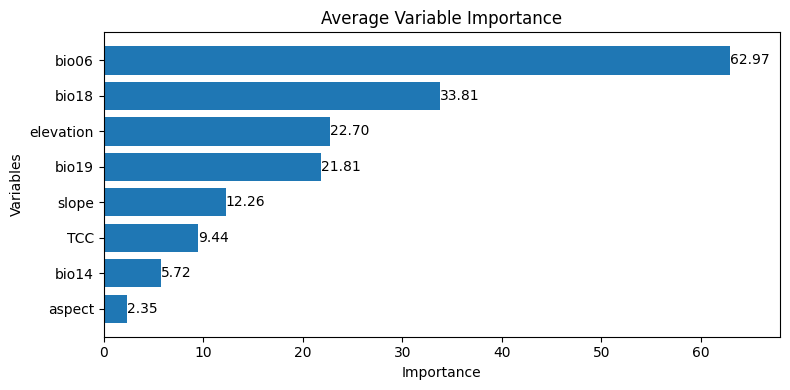

In [205]:
plot_variable_importance(importances_list)

# AUC-ROC and AUC-PR for each run
Using the Testing Datasets, calculate AUC-ROC and AUC-PR for each run. Then, compute the average AUC-ROC and AUC-PR over n iterations.

AUC-ROC represents the area under the curve of the 'Sensitivity (Recall) vs. 1-Specificity' graph, illustrating the relationship between sensitivity and specificity as the threshold changes. Specificity is based on all observed non-occurrences. Therefore, AUC-ROC encompasses all quadrants of the confusion matrix.

AUC-PR represents the area under the curve of the 'Precision vs. Recall (Sensitivity)' graph, showing the relationship between precision and recall as the threshold varies. Precision is based on all predicted occurrences. Hence, AUC-PR does not include the true negatives (TN).

In [206]:
def print_pres_abs_sizes(TestingDatasets, numiter):
    # Check and print the sizes of presence and pseudo-absence coordinates
    def get_pres_abs_size(x):
        fc = ee.FeatureCollection(TestingDatasets.get(x))
        presence_size = fc.filter(ee.Filter.eq("PresAbs", 1)).size()
        pseudo_absence_size = fc.filter(ee.Filter.eq("PresAbs", 0)).size()
        return ee.List([presence_size, pseudo_absence_size])

    sizes_info = (
        ee.List.sequence(0, ee.Number(numiter).subtract(1), 1)
        .map(get_pres_abs_size)
        .getInfo()
    )

    for i, sizes in enumerate(sizes_info):
        presence_size = sizes[0]
        pseudo_absence_size = sizes[1]
        print(
            f"Iteration {i + 1}: Presence Size = {presence_size}, Pseudo-absence Size = {pseudo_absence_size}"
        )

In [207]:
# Extracting the Testing Datasets
testing_datasets = ee.List.sequence(
    3, ee.Number(numiter).multiply(4).subtract(1), 4
).map(lambda x: results.get(x))

print_pres_abs_sizes(testing_datasets, numiter)

Iteration 1: Presence Size = 14, Pseudo-absence Size = 14
Iteration 2: Presence Size = 14, Pseudo-absence Size = 14
Iteration 3: Presence Size = 14, Pseudo-absence Size = 14
Iteration 4: Presence Size = 14, Pseudo-absence Size = 14
Iteration 5: Presence Size = 14, Pseudo-absence Size = 14
Iteration 6: Presence Size = 14, Pseudo-absence Size = 14
Iteration 7: Presence Size = 14, Pseudo-absence Size = 14
Iteration 8: Presence Size = 14, Pseudo-absence Size = 14
Iteration 9: Presence Size = 14, Pseudo-absence Size = 14
Iteration 10: Presence Size = 14, Pseudo-absence Size = 14


In [208]:
def get_acc(hsm, t_data, grid_size):
    pr_prob_vals = hsm.sampleRegions(
        collection=t_data, properties=["PresAbs"], scale=grid_size
    )
    seq = ee.List.sequence(start=0, end=1, count=25)  # Divide 0 to 1 into 25 intervals

    def calculate_metrics(cutoff):
        # Each element of the seq list is passed as cutoff(threshold value)

        # Observed present = TP + FN
        pres = pr_prob_vals.filterMetadata("PresAbs", "equals", 1)

        # TP (True Positive)
        tp = ee.Number(
            pres.filterMetadata("classification", "greater_than", cutoff).size()
        )

        # TPR (True Positive Rate) = Recall = Sensitivity = TP / (TP + FN) = TP / Observed present
        tpr = tp.divide(pres.size())

        # Observed absent = FP + TN
        abs = pr_prob_vals.filterMetadata("PresAbs", "equals", 0)

        # FN (False Negative)
        fn = ee.Number(
            pres.filterMetadata("classification", "less_than", cutoff).size()
        )

        # TNR (True Negative Rate) = Specificity = TN  / (FP + TN) = TN / Observed absent
        tn = ee.Number(abs.filterMetadata("classification", "less_than", cutoff).size())
        tnr = tn.divide(abs.size())

        # FP (False Positive)
        fp = ee.Number(
            abs.filterMetadata("classification", "greater_than", cutoff).size()
        )

        # FPR (False Positive Rate) = FP / (FP + TN) = FP / Observed absent
        fpr = fp.divide(abs.size())

        # Precision = TP / (TP + FP) = TP / Predicted present
        precision = tp.divide(tp.add(fp))

        # SUMSS = SUM of Sensitivity and Specificity
        sumss = tpr.add(tnr)

        return ee.Feature(
            None,
            {
                "cutoff": cutoff,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "TPR": tpr,
                "TNR": tnr,
                "FPR": fpr,
                "Precision": precision,
                "SUMSS": sumss,
            },
        )

    return ee.FeatureCollection(seq.map(calculate_metrics))

In [209]:
def calculate_and_print_auc_metrics(images, testing_datasets, grid_size, numiter):
    # Calculate AUC-ROC and AUC-PR
    def calculate_auc_metrics(x):
        hsm = ee.Image(images.get(x))
        t_data = ee.FeatureCollection(testing_datasets.get(x))
        acc = get_acc(hsm, t_data, grid_size)

        # Calculate AUC-ROC
        x = ee.Array(acc.aggregate_array("FPR"))
        y = ee.Array(acc.aggregate_array("TPR"))
        x1 = x.slice(0, 1).subtract(x.slice(0, 0, -1))
        y1 = y.slice(0, 1).add(y.slice(0, 0, -1))
        auc_roc = x1.multiply(y1).multiply(0.5).reduce("sum", [0]).abs().toList().get(0)

        # Calculate AUC-PR
        x = ee.Array(acc.aggregate_array("TPR"))
        y = ee.Array(acc.aggregate_array("Precision"))
        x1 = x.slice(0, 1).subtract(x.slice(0, 0, -1))
        y1 = y.slice(0, 1).add(y.slice(0, 0, -1))
        auc_pr = x1.multiply(y1).multiply(0.5).reduce("sum", [0]).abs().toList().get(0)

        return (auc_roc, auc_pr)

    auc_metrics = (
        ee.List.sequence(0, ee.Number(numiter).subtract(1), 1)
        .map(calculate_auc_metrics)
        .getInfo()
    )

    # Print AUC-ROC and AUC-PR for each iteration
    df = pd.DataFrame(auc_metrics, columns=["AUC-ROC", "AUC-PR"])
    df.index = [f"Iteration {i + 1}" for i in range(len(df))]
    df.to_csv("auc_metrics.csv", index_label="Iteration")
    print(df)

    # Calculate mean and standard deviation of AUC-ROC and AUC-PR
    mean_auc_roc, std_auc_roc = df["AUC-ROC"].mean(), df["AUC-ROC"].std()
    mean_auc_pr, std_auc_pr = df["AUC-PR"].mean(), df["AUC-PR"].std()
    print(f"Mean AUC-ROC = {mean_auc_roc:.4f} ± {std_auc_roc:.4f}")
    print(f"Mean AUC-PR = {mean_auc_pr:.4f} ± {std_auc_pr:.4f}")

In [244]:
%%time

# Calculate AUC-ROC and AUC-PR
calculate_and_print_auc_metrics(images, testing_datasets, grid_size, numiter)

EEException: User memory limit exceeded.